## Problem Statement:
Develop a predictive model to identify and classify potential loan defaulters based on historical customer data and relevant features.
When the company receives a loan application, the company has to decide for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.

The data given below contains the information about the loan application at the time of applying for the loan.

## Imports

In [1]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd 
from numpy import percentile
import matplotlib.pyplot as plt
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import OneClassSVM
from skopt import BayesSearchCV
import imblearn
print(imblearn.__version__)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , accuracy_score ,f1_score ,precision_score,recall_score
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 500)

0.11.0


## Read dataset

In [2]:
data=pd.read_csv("application_data.csv") 

## Data Information

In [3]:
data.shape

(307511, 122)

In [4]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [6]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [7]:
data=data.drop(['SK_ID_CURR'],axis=1)

## Handling missing values and Splitting the data

In [8]:
data.isnull().sum()

TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE                     0
FLAG_PHONE               

In [9]:
column_name ='CODE_GENDER','ORGANIZATION_TYPE'
for s in column_name:
    data[s] = data[s].replace('XNA', np.nan)


In [10]:
x=data.loc[:, data.columns != 'TARGET']
y=data.loc[:,['TARGET']]

StratifiedShuffleSplit.
Is a cross-validation technique used for splitting the dataset
while maintaining the same distribution of target classes in both sets.

In [11]:
# Create instance of StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets
for train_index, test_index in split.split(x, y):
    x_train = x.loc[train_index]
    x_test = x.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

In [12]:
x_train.shape

(246008, 120)

In [13]:
x_test.shape

(61503, 120)

In [14]:
categorical_columns = x_train.select_dtypes(include=['object']).columns
numerical_columns = x_train.select_dtypes(include=['int64', 'float64']).columns
numerical_data = x_train.select_dtypes(include=['int64', 'float64'])


In [15]:
imputer_cat = SimpleImputer(strategy='most_frequent')
x_train[categorical_columns] = imputer_cat.fit_transform(x_train[categorical_columns])
x_test[categorical_columns] = imputer_cat.transform(x_test[categorical_columns])

In [16]:
imputer_num = SimpleImputer(strategy='median')
x_train[numerical_columns] = imputer_num.fit_transform(x_train[numerical_columns])
x_test[numerical_columns] = imputer_num.transform(x_test[numerical_columns])

In [17]:
x_train.isnull().sum()

NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_CLIENT            0
REGION_RATING_

In [18]:
x_test.isnull().sum()

NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBERS                 0
REGION_RATING_CLIENT            0
REGION_RATING_

## Data Visualization

Numerical analysis

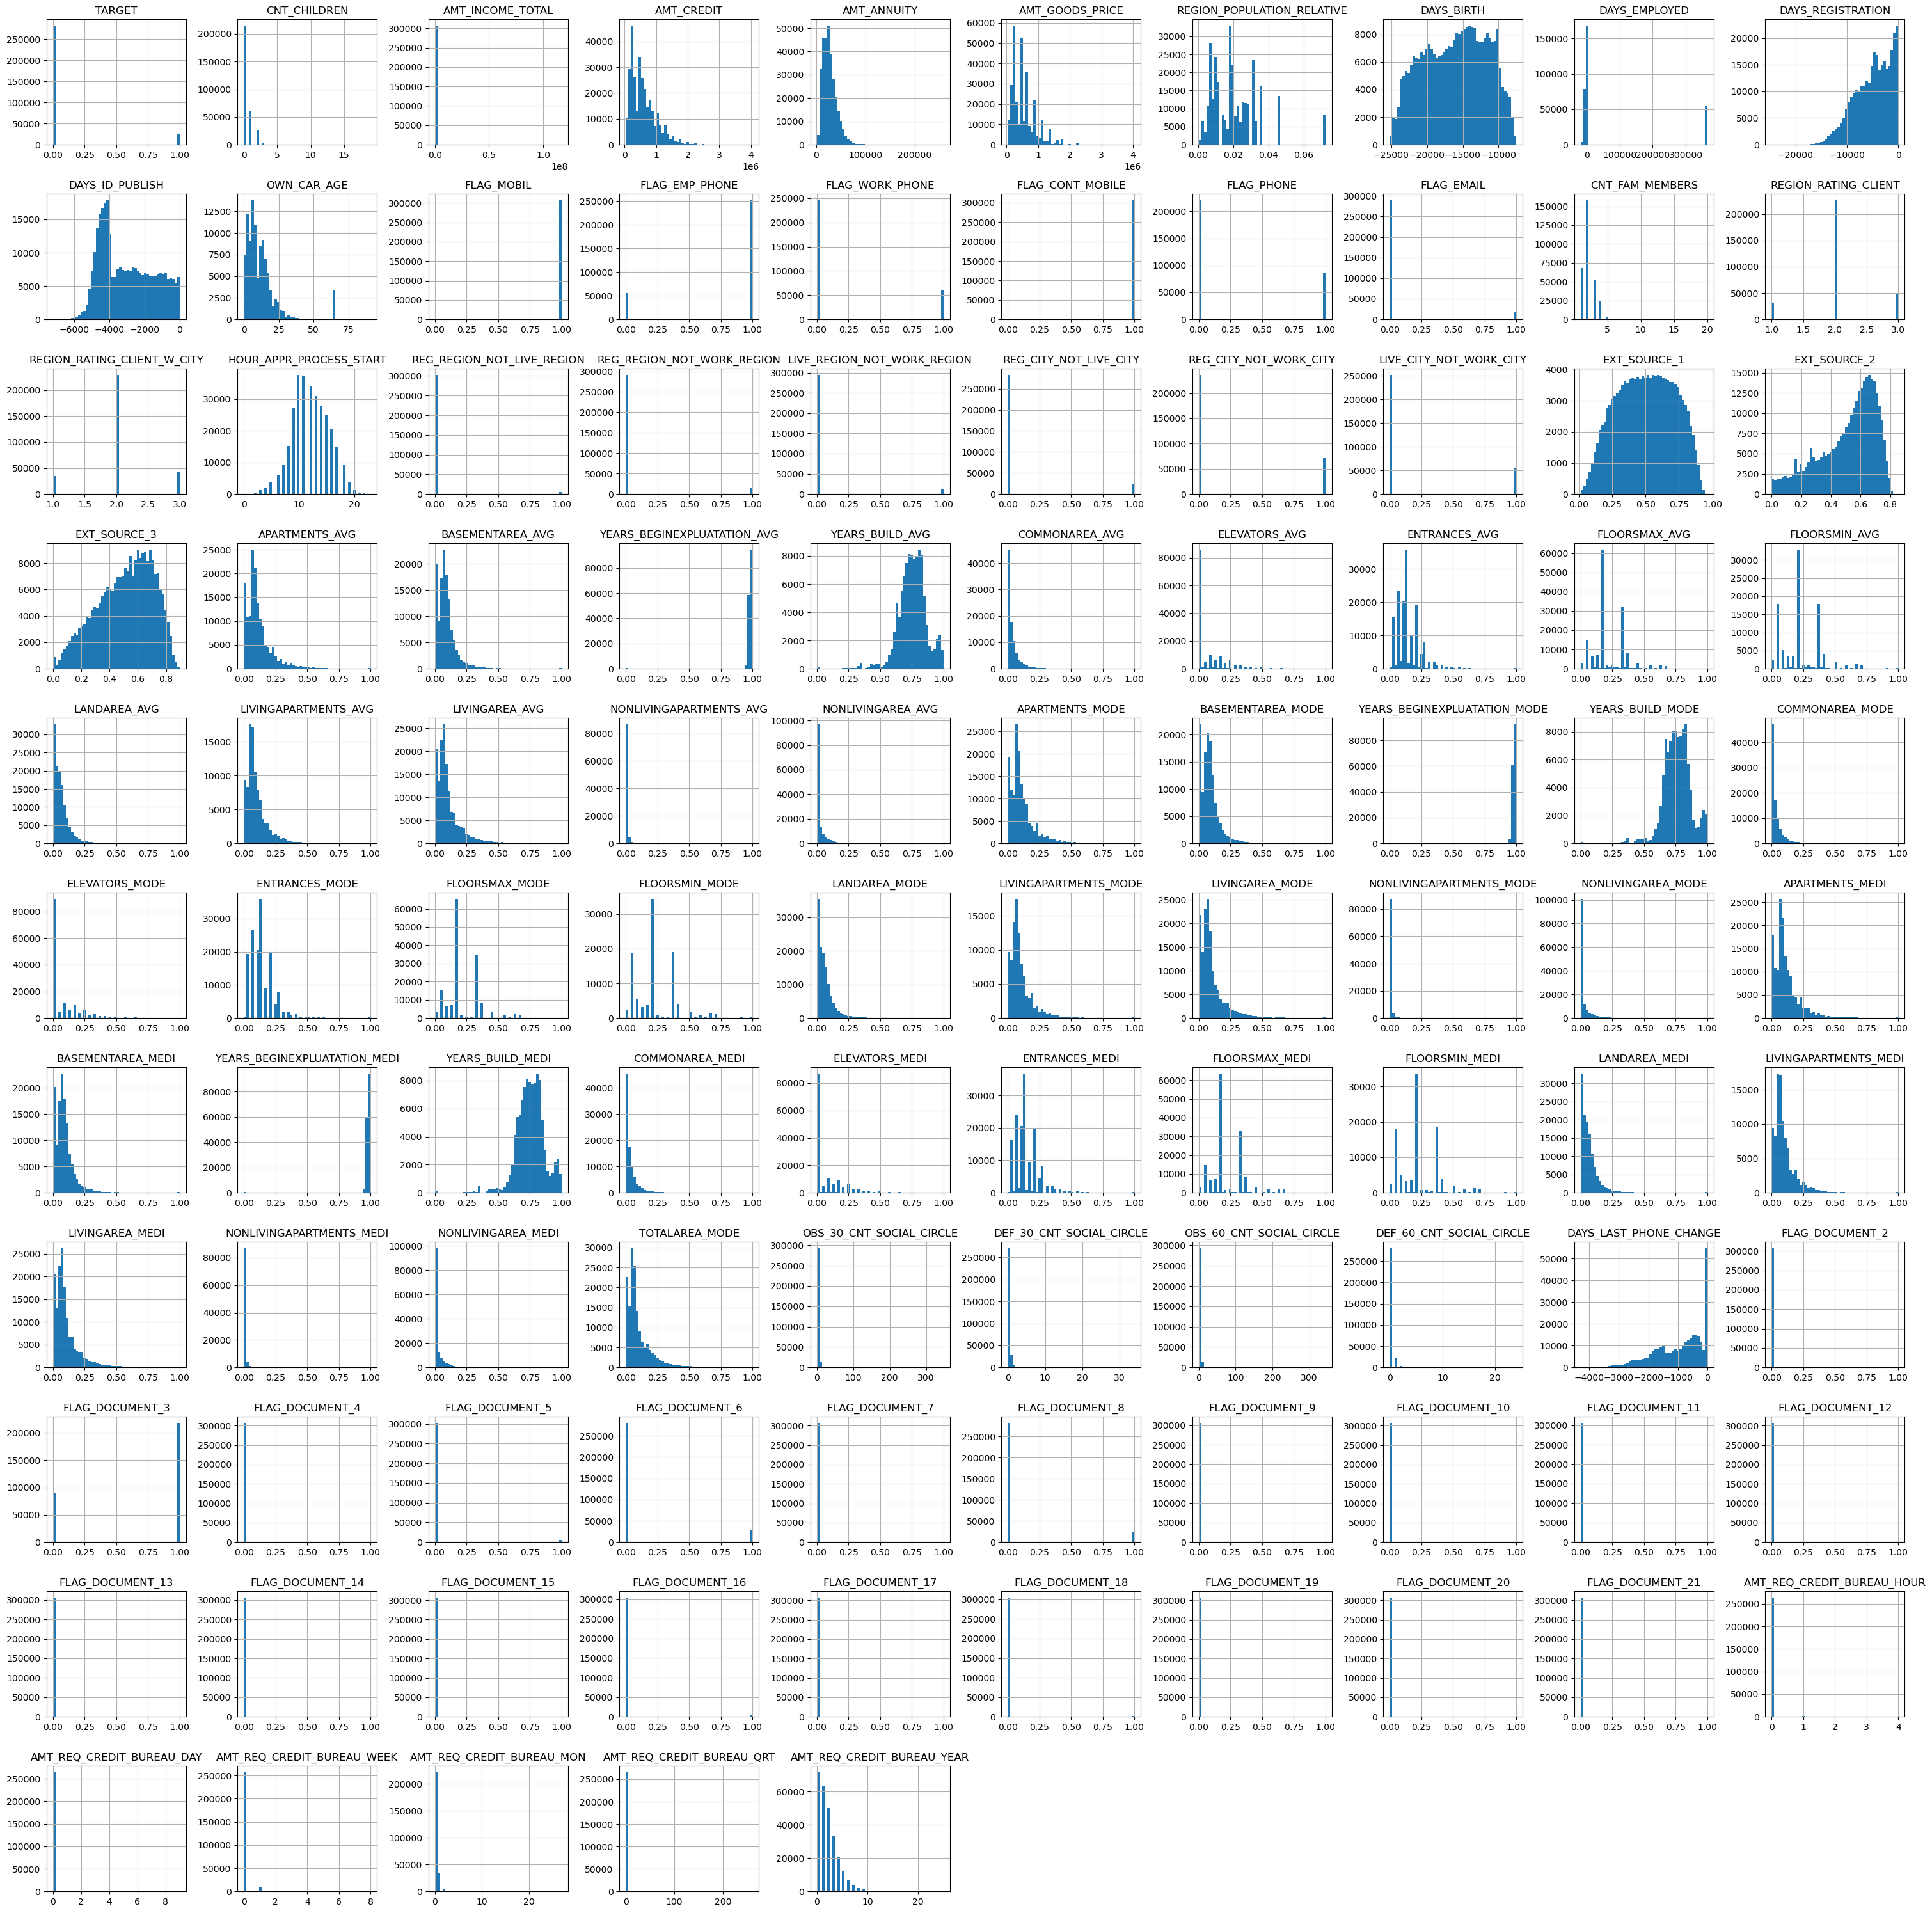

In [19]:
data.hist(figsize=(30, 30), bins=50)
plt.tight_layout()


## Categorical analysis

In [20]:
print(data.nunique())


TARGET                               2
NAME_CONTRACT_TYPE                   2
CODE_GENDER                          2
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
CNT_CHILDREN                        15
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
NAME_TYPE_SUITE                      7
NAME_INCOME_TYPE                     8
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE                     2
FLAG_PHONE               

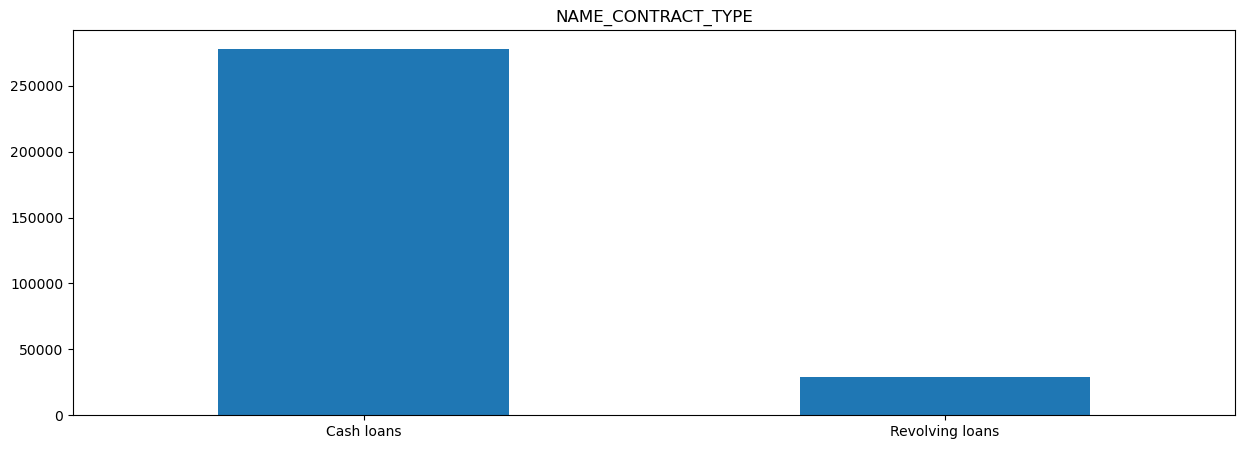

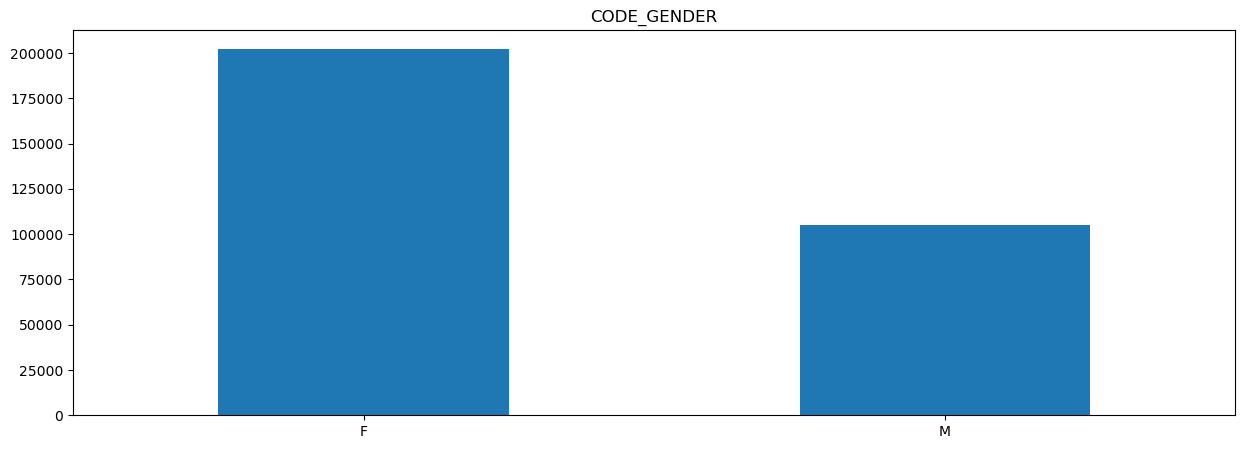

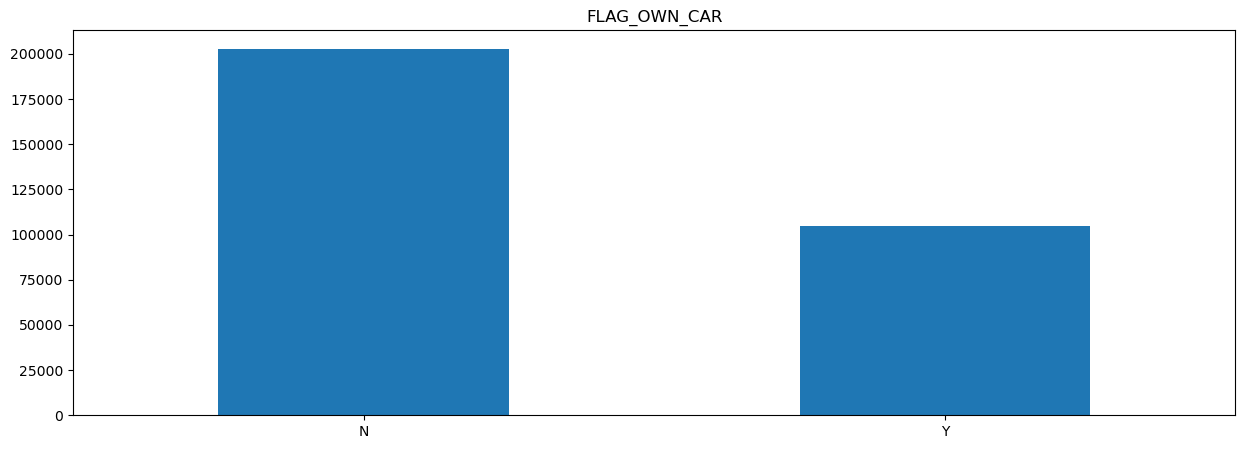

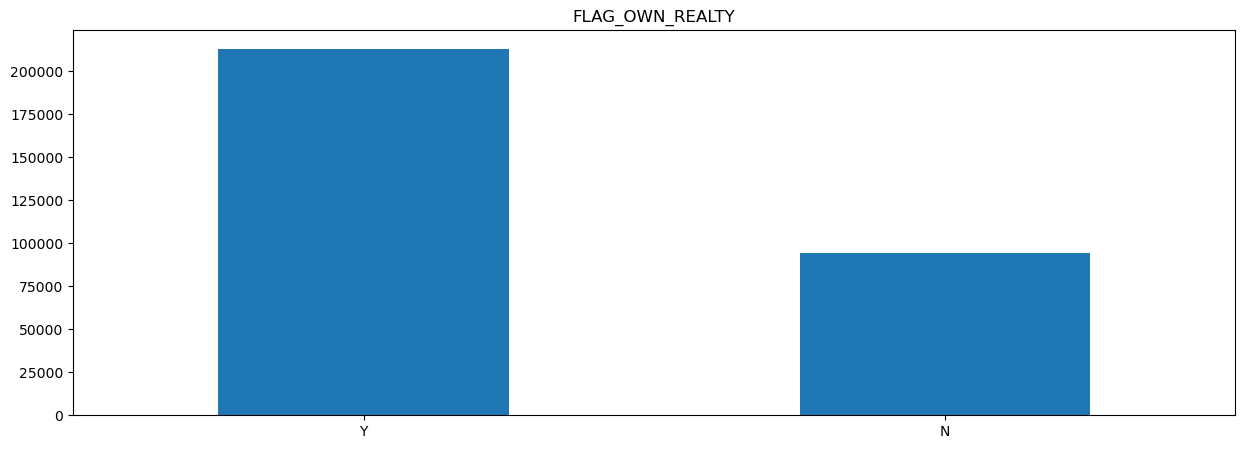

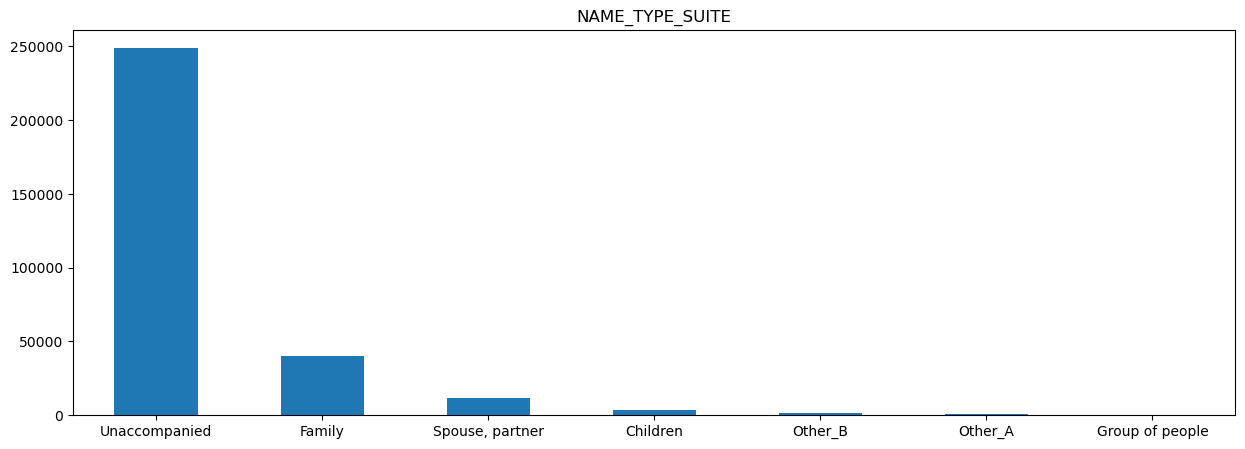

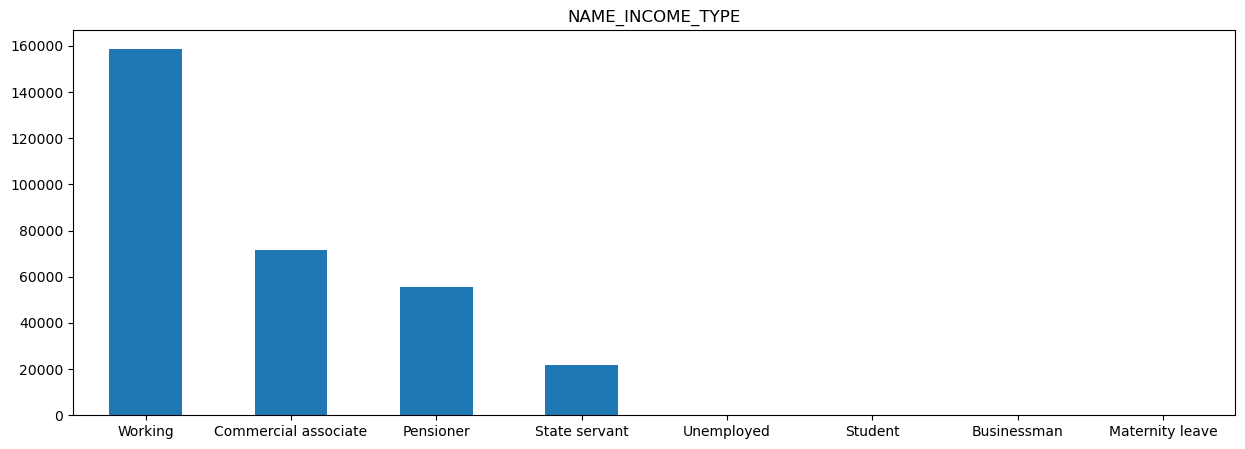

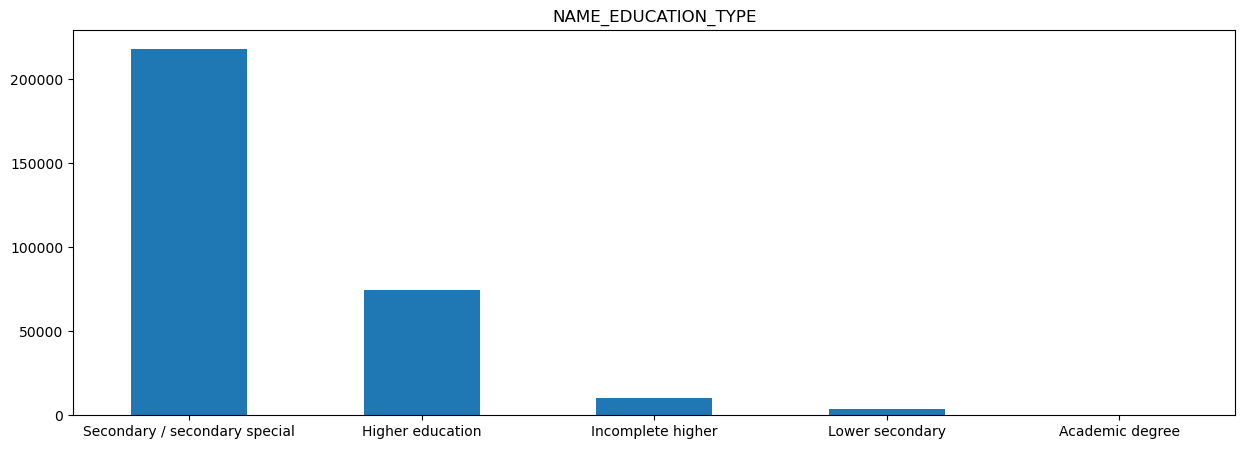

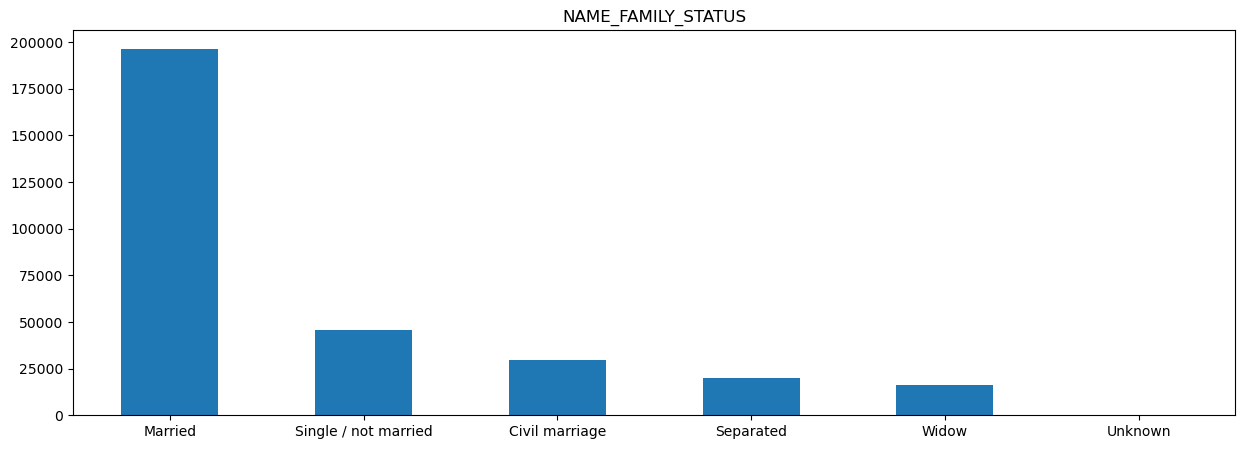

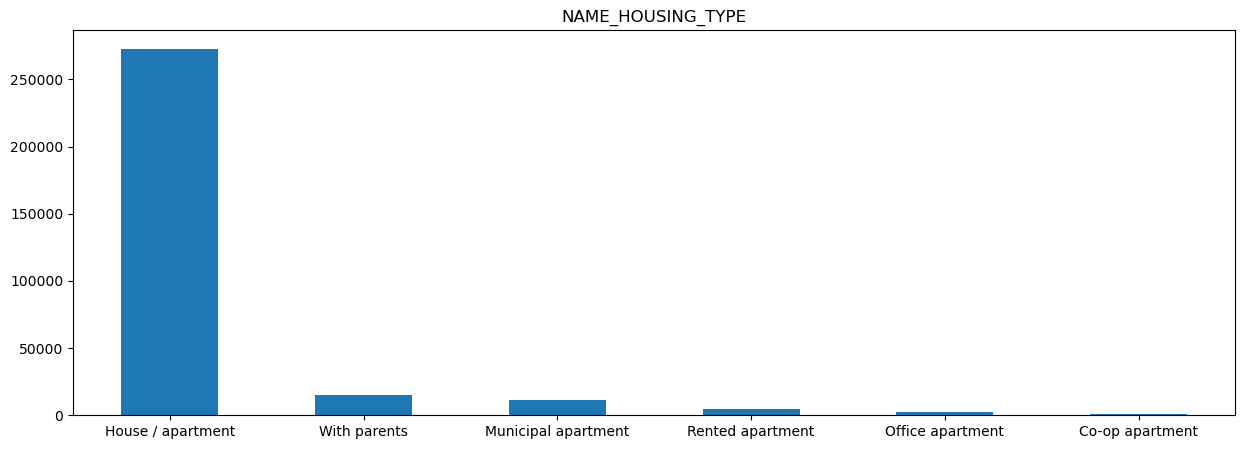

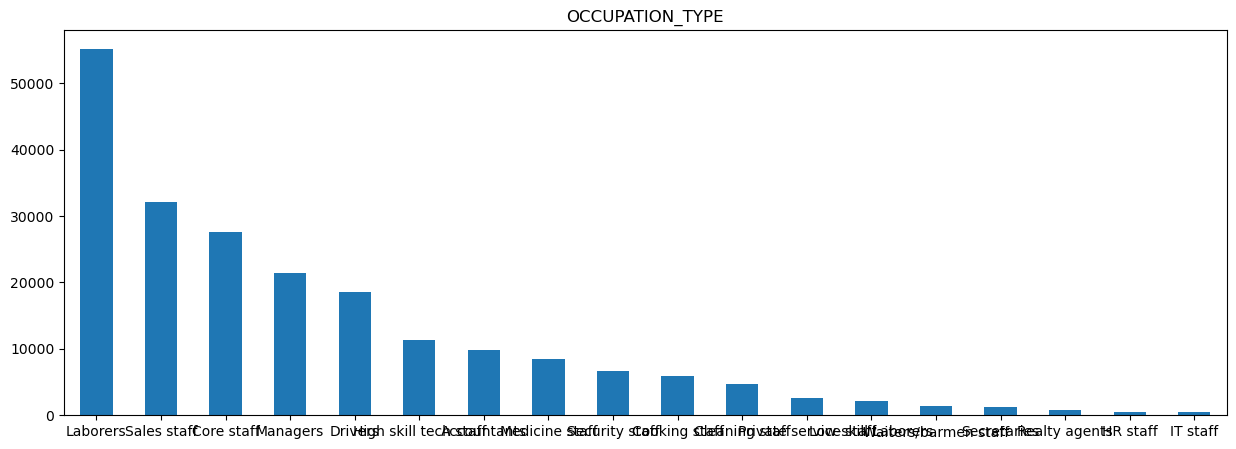

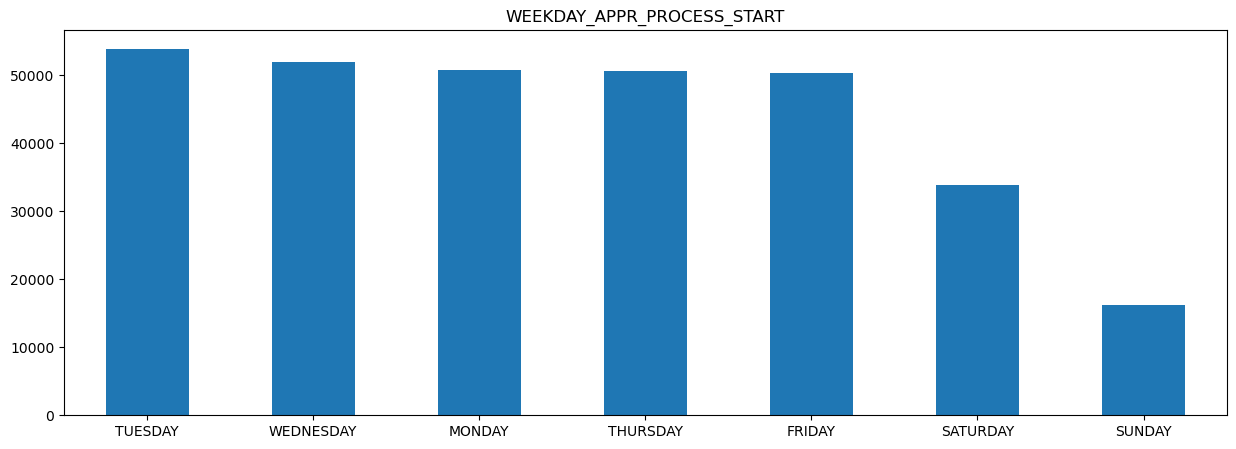

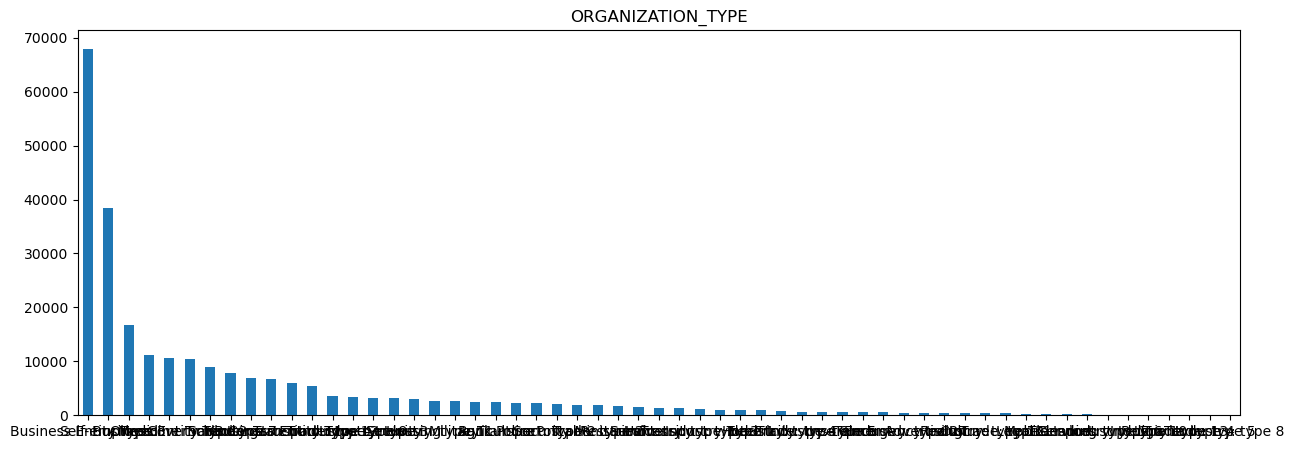

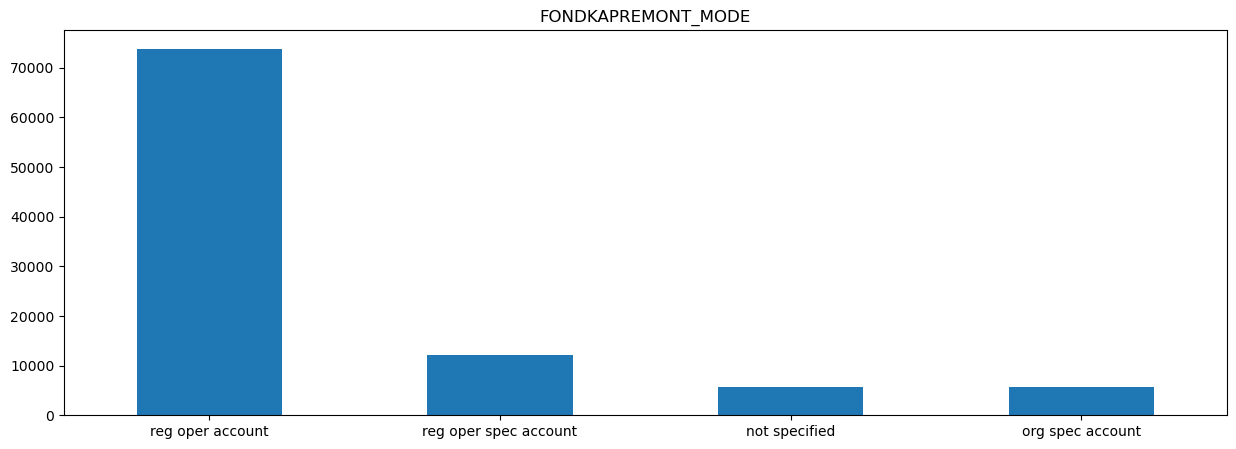

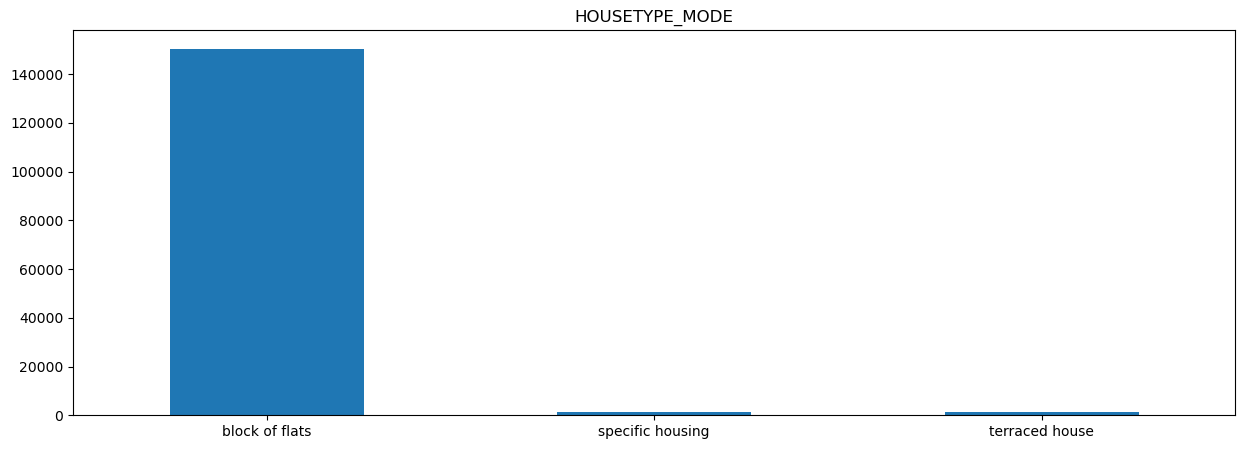

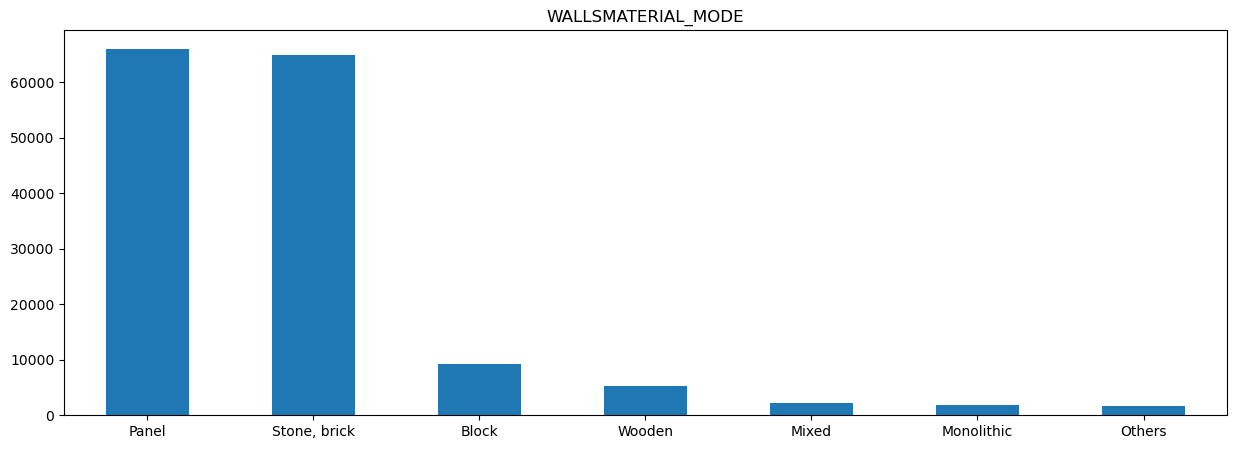

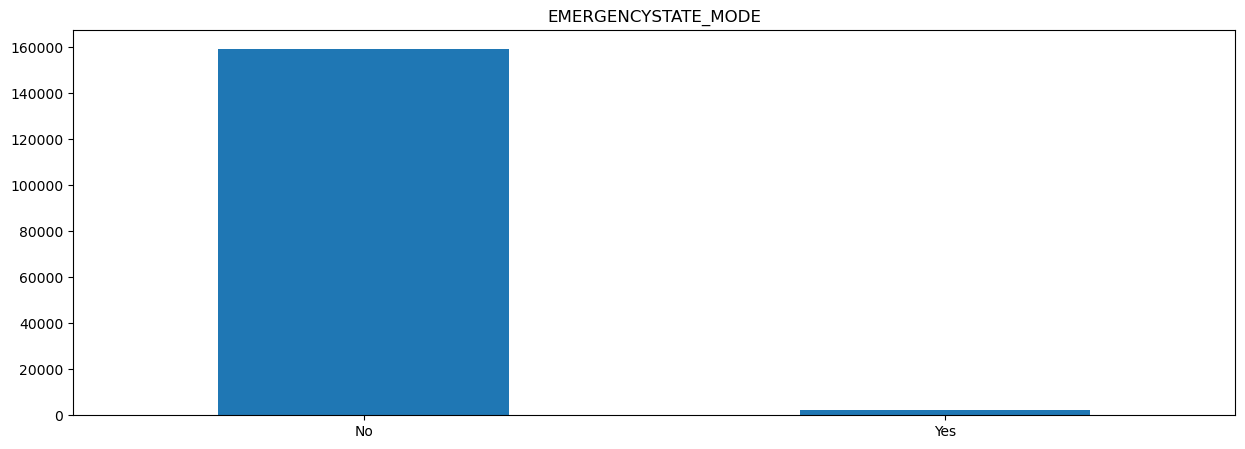

In [21]:
for s in categorical_columns:
   fig = plt.figure(figsize =(15,5))
   data[s].value_counts().plot(kind='bar', rot=0).set_title(s)
   plt.show()

## box plots
for plotting outliers
 

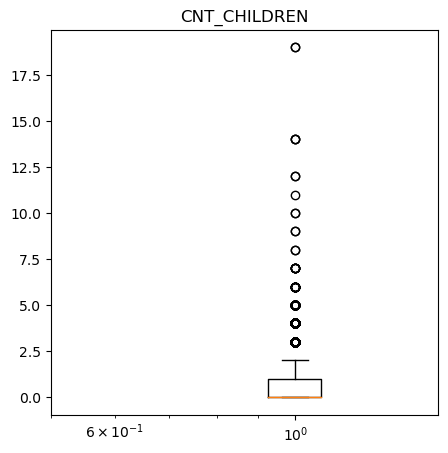

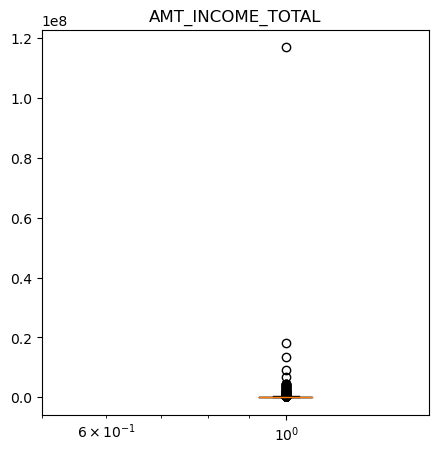

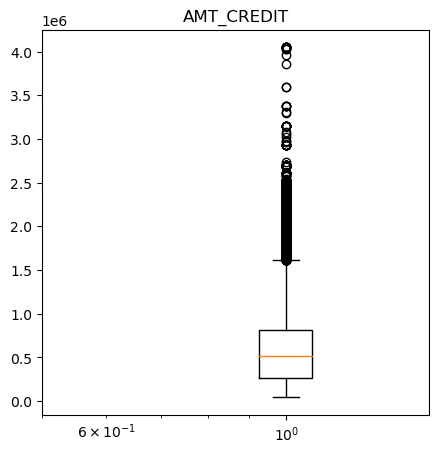

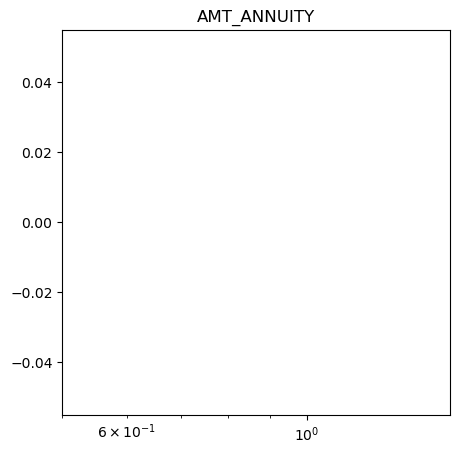

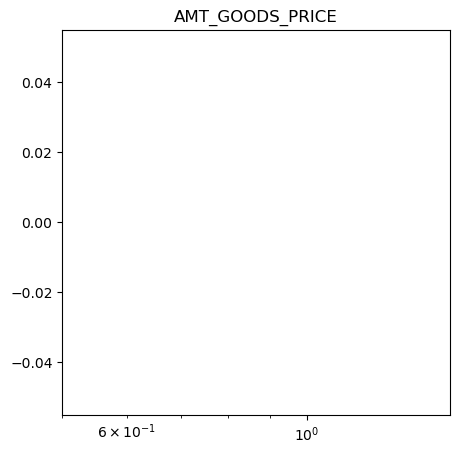

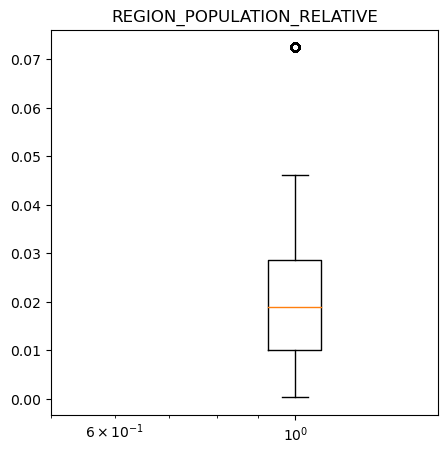

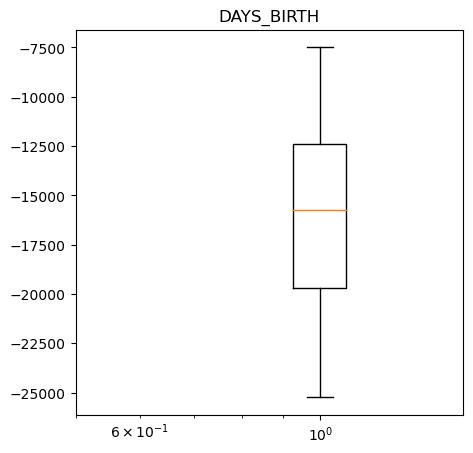

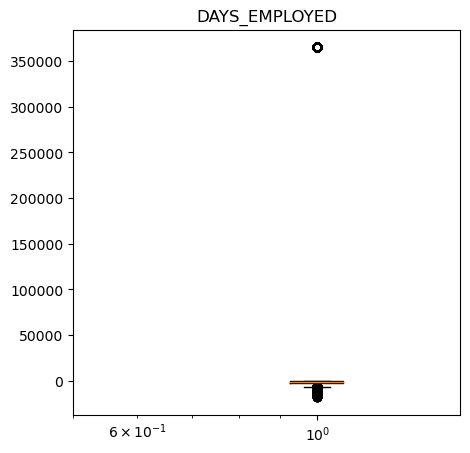

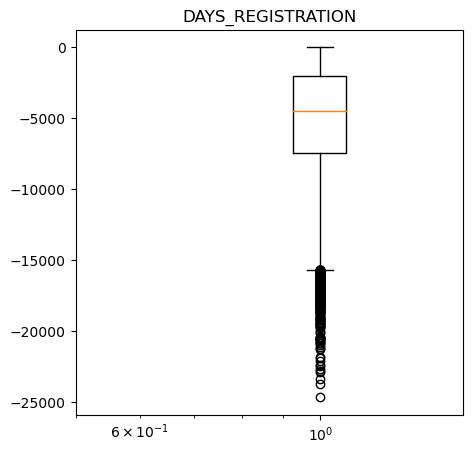

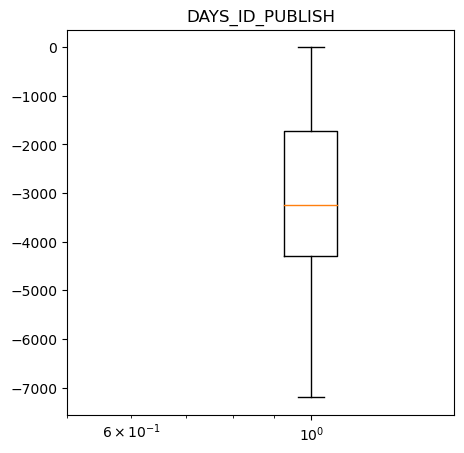

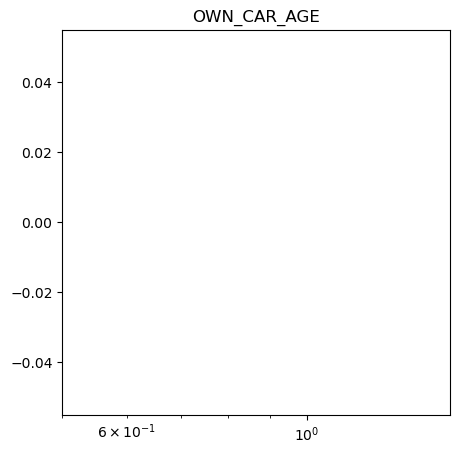

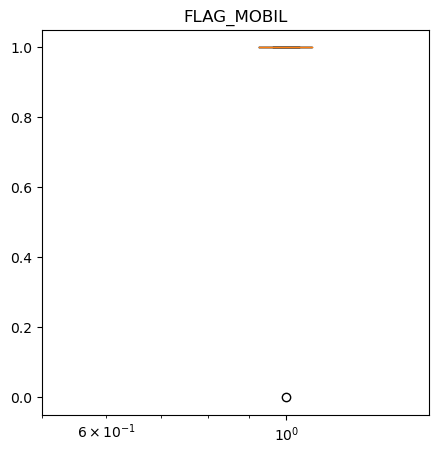

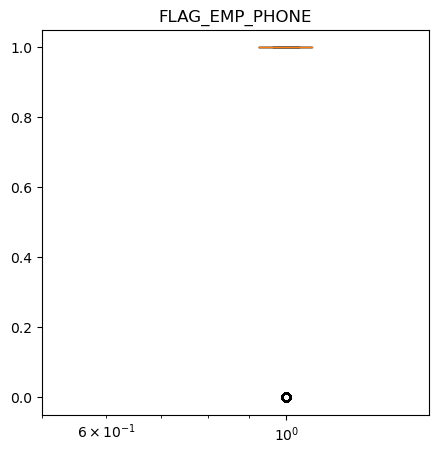

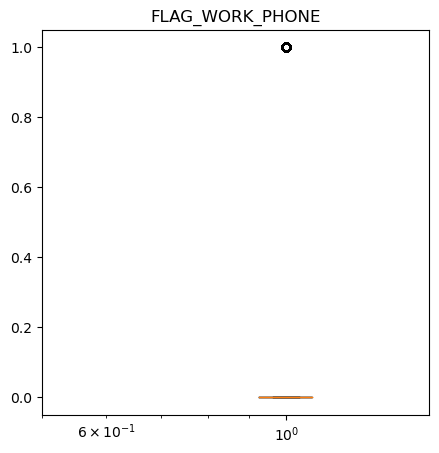

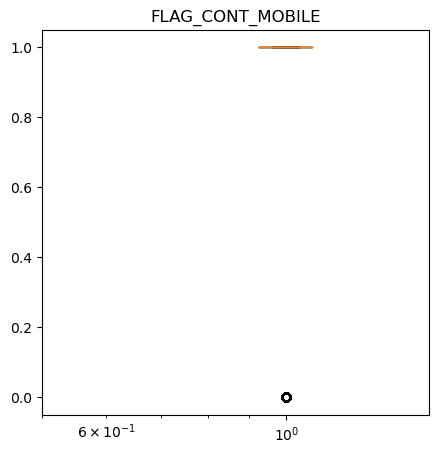

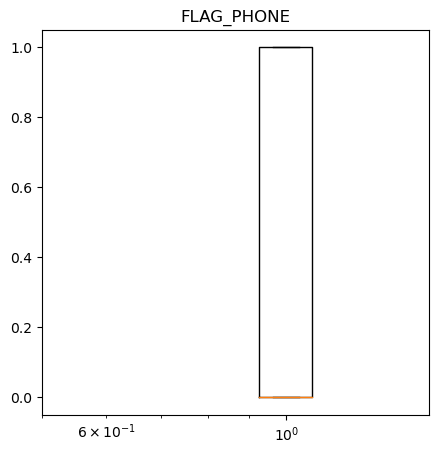

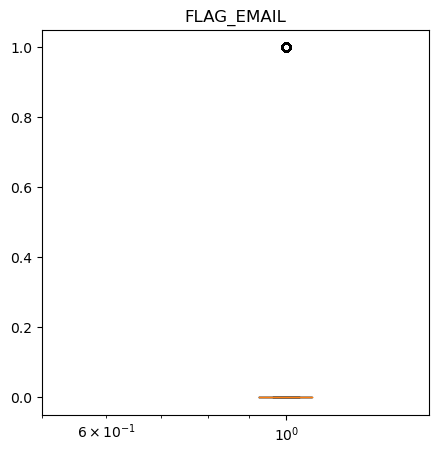

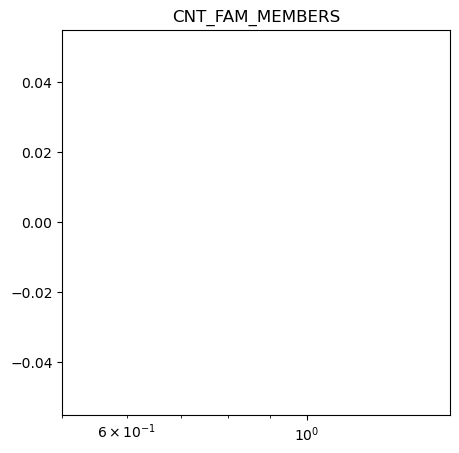

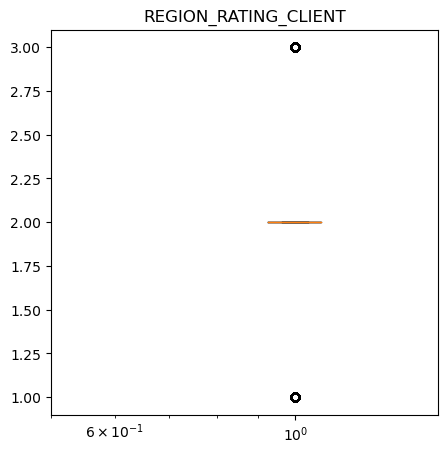

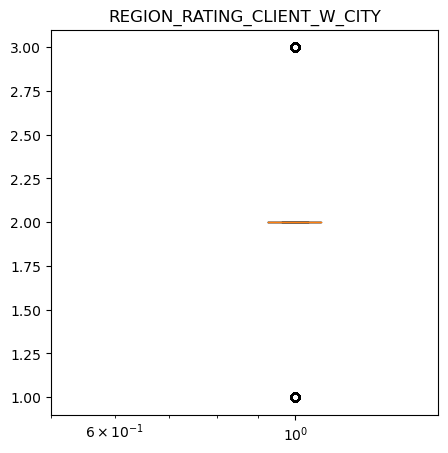

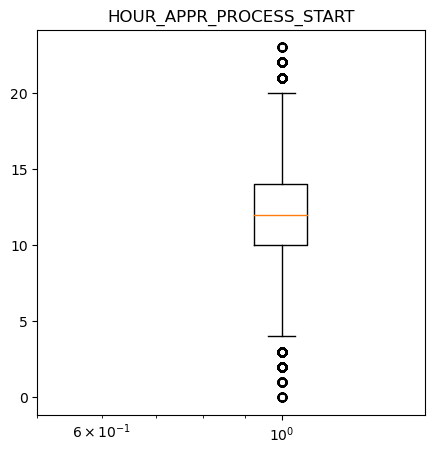

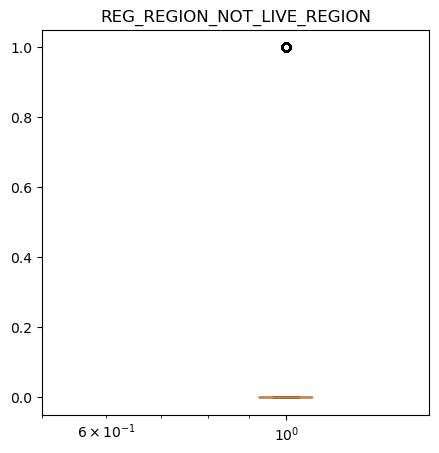

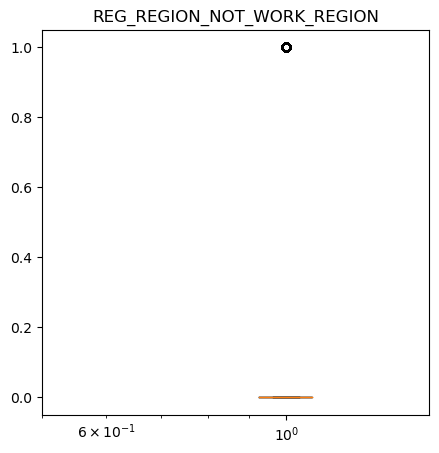

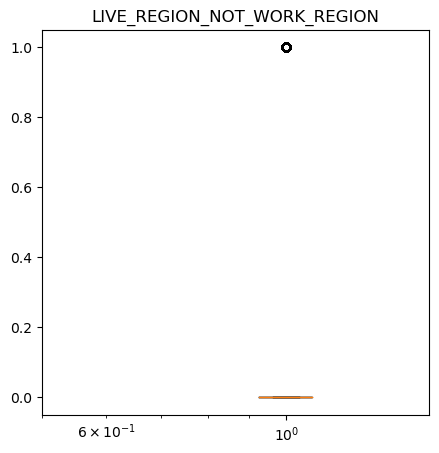

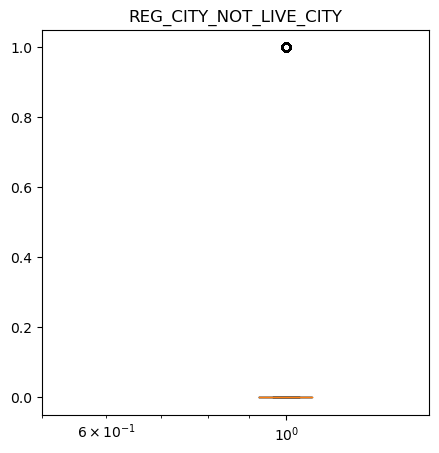

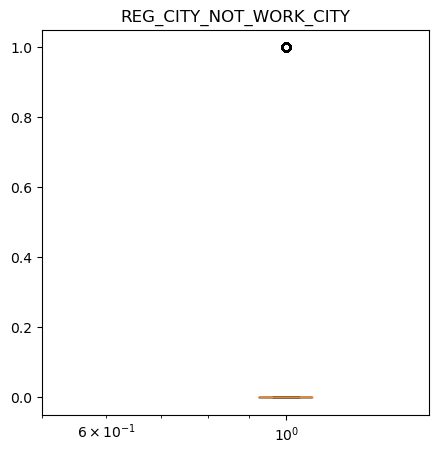

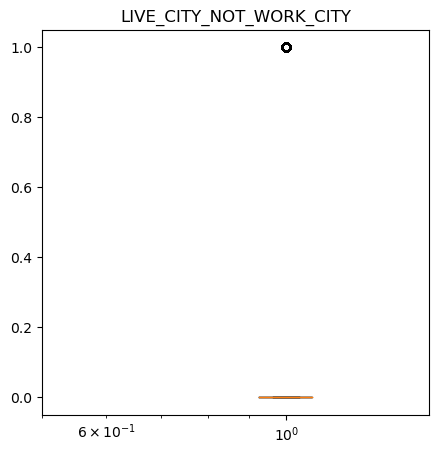

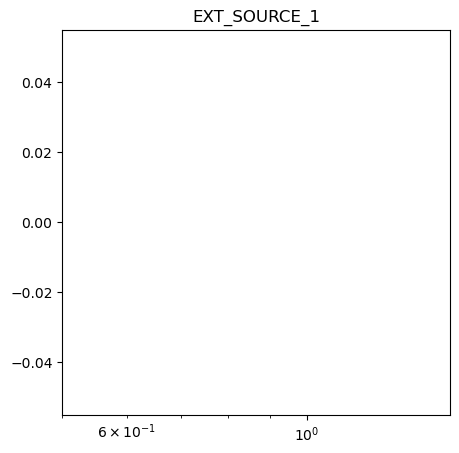

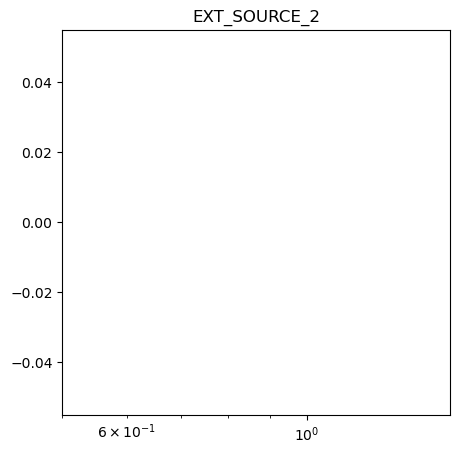

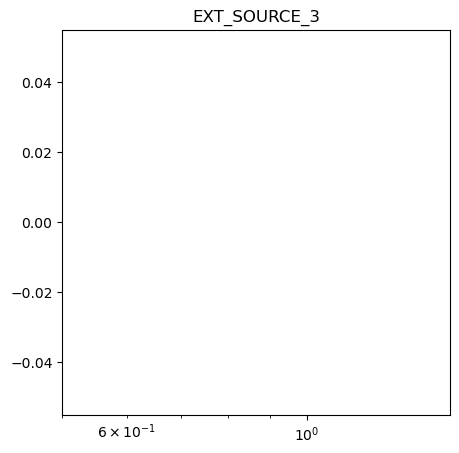

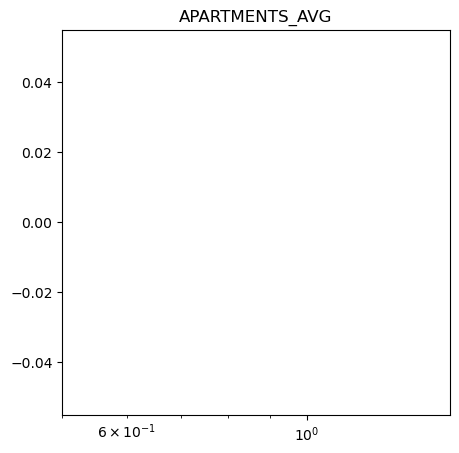

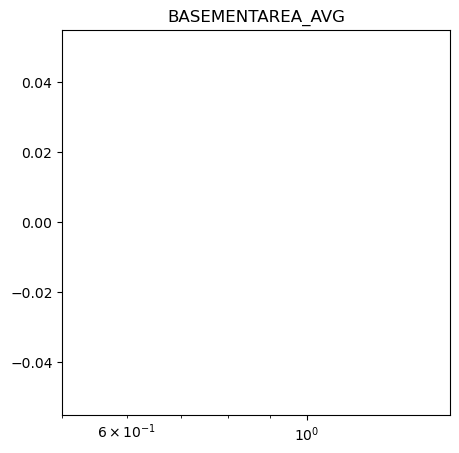

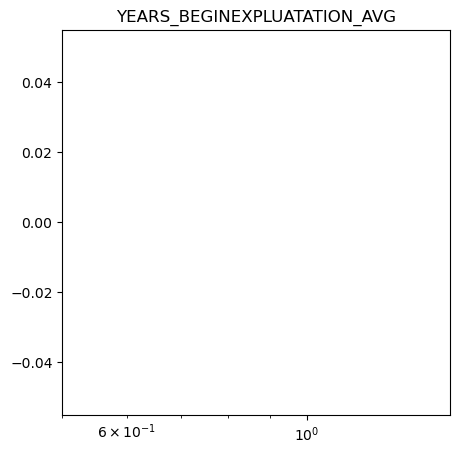

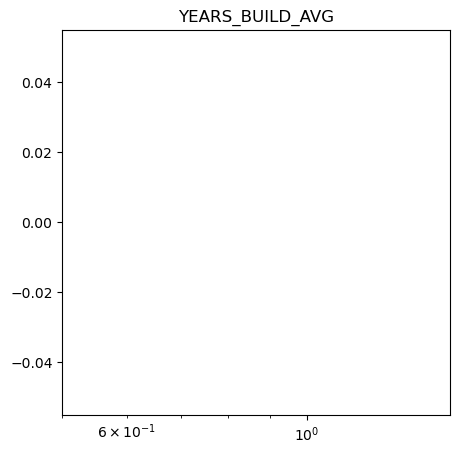

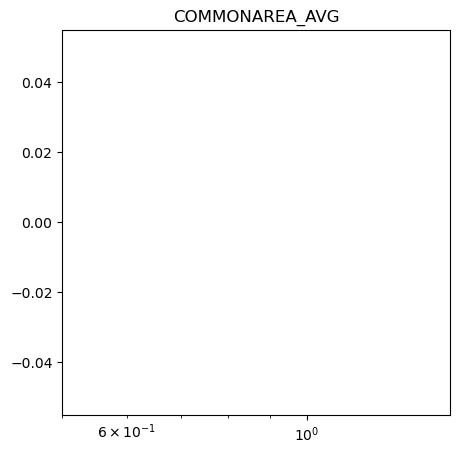

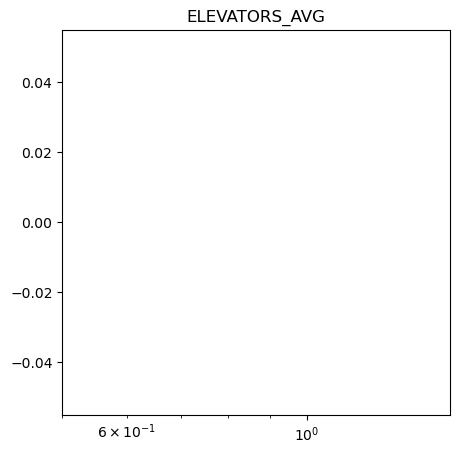

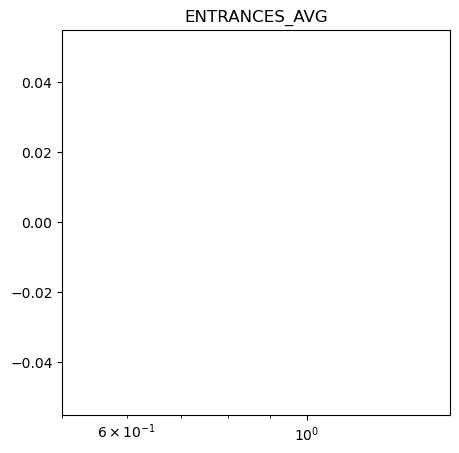

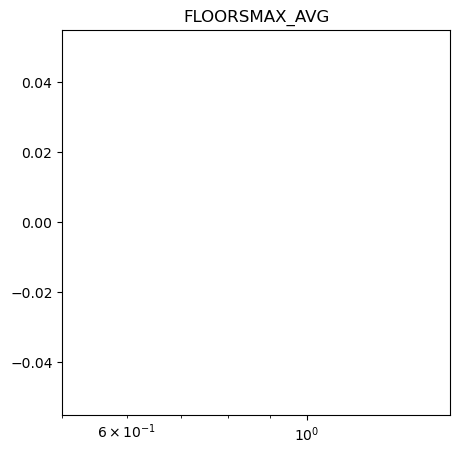

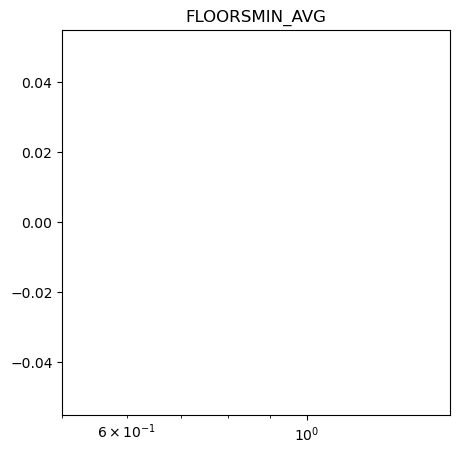

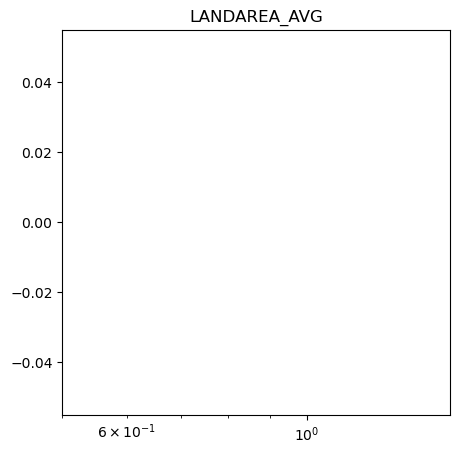

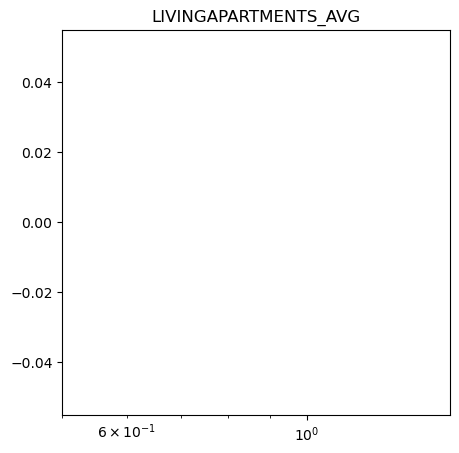

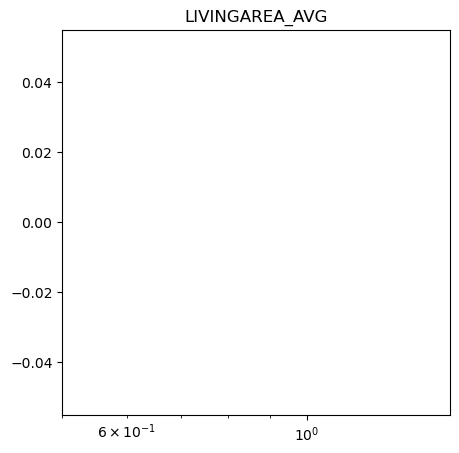

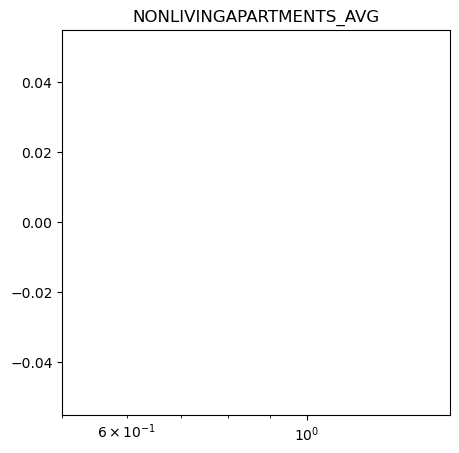

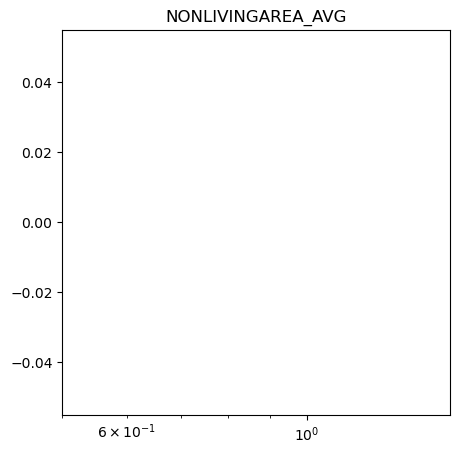

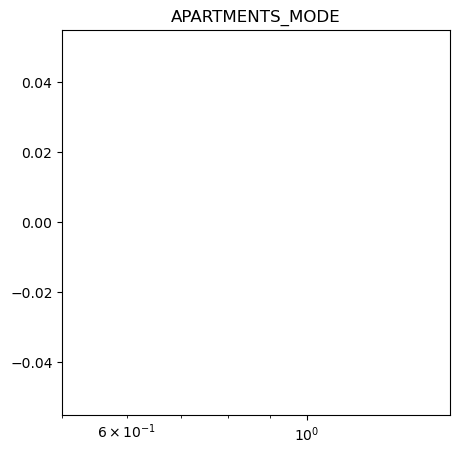

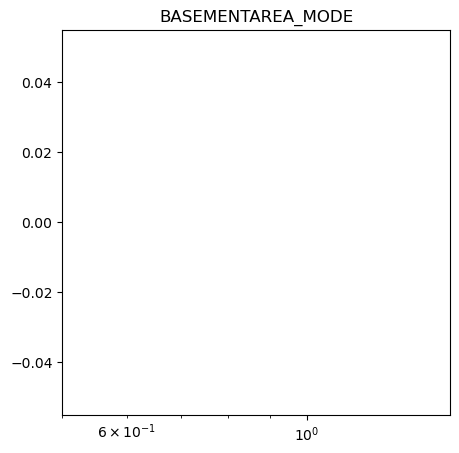

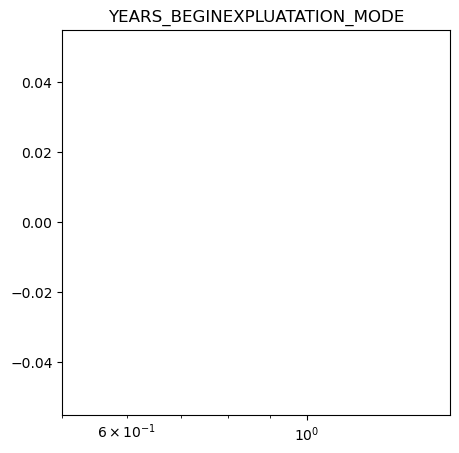

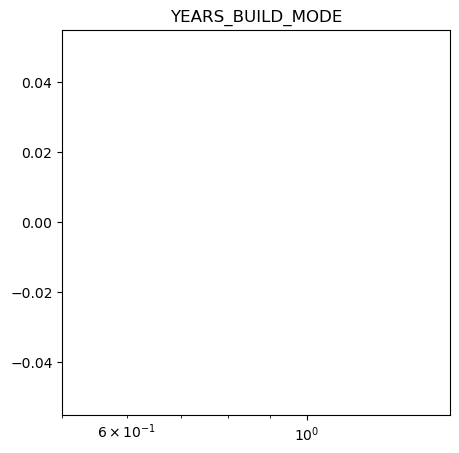

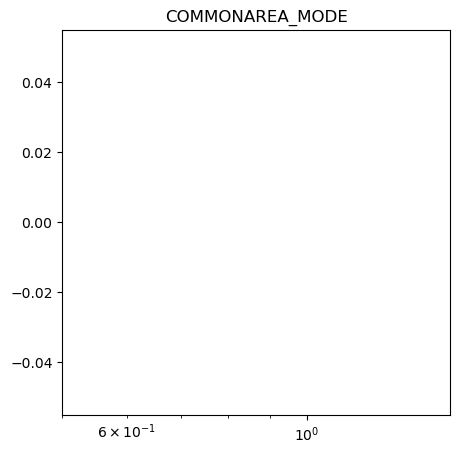

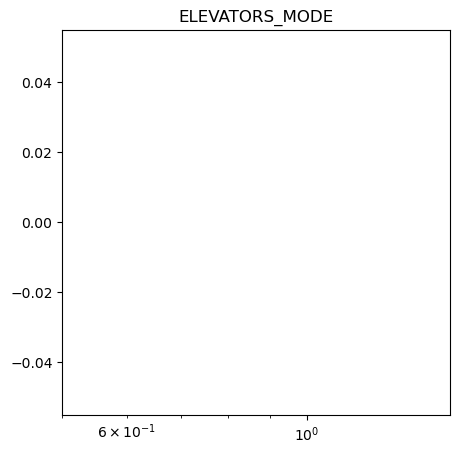

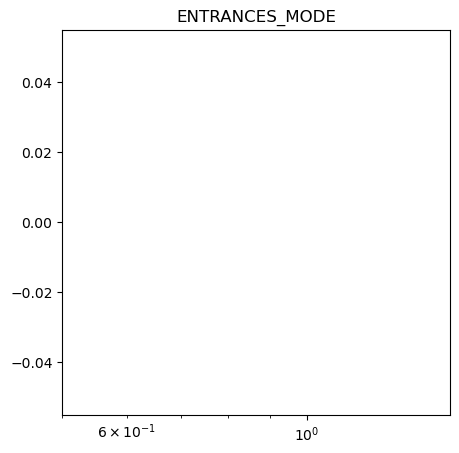

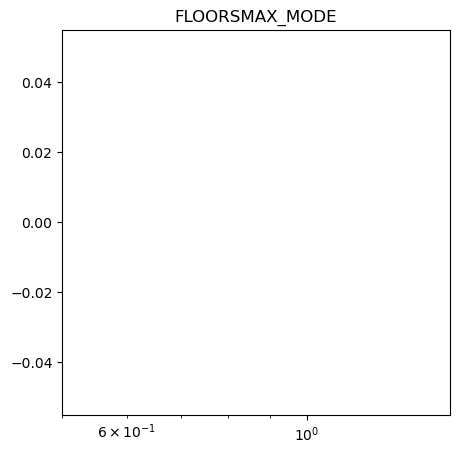

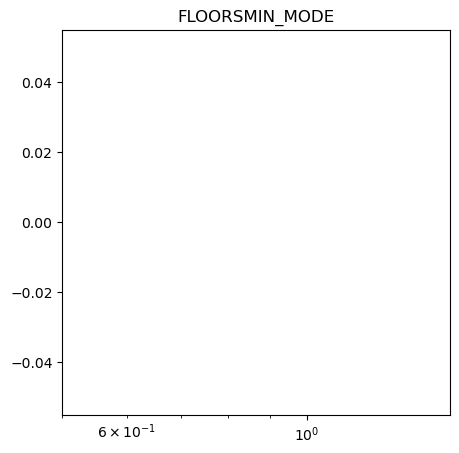

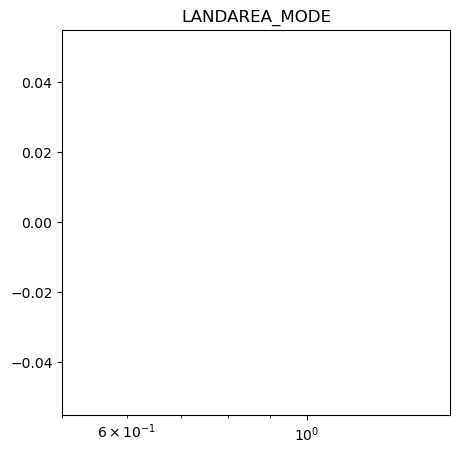

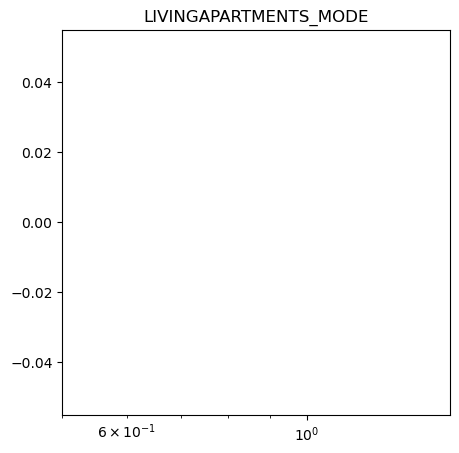

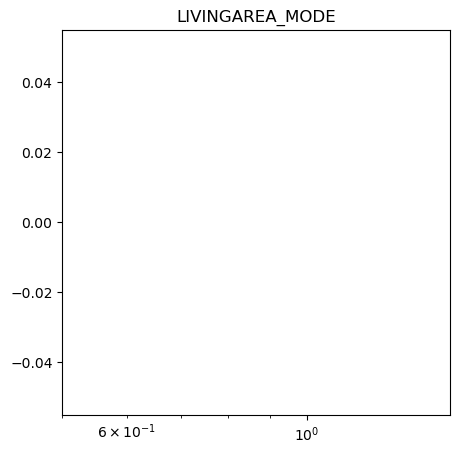

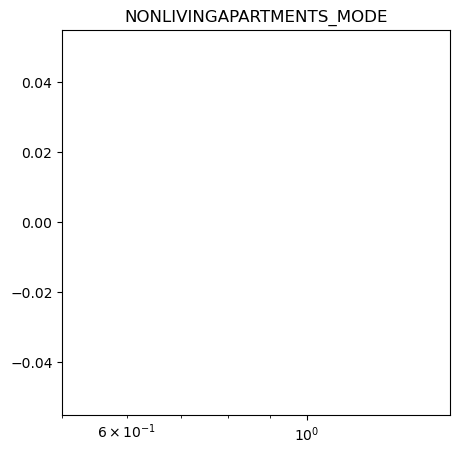

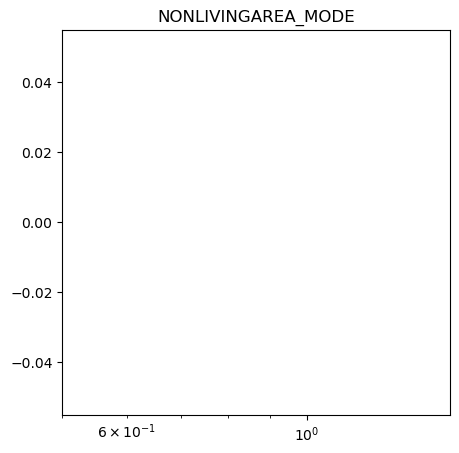

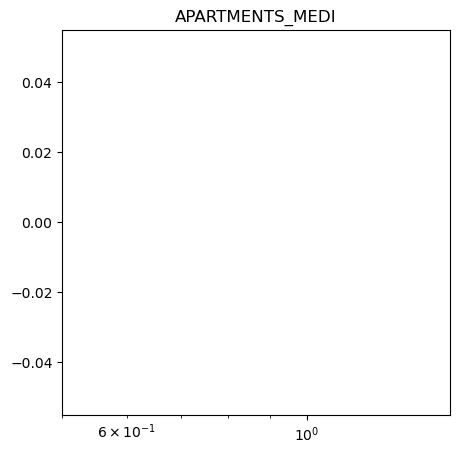

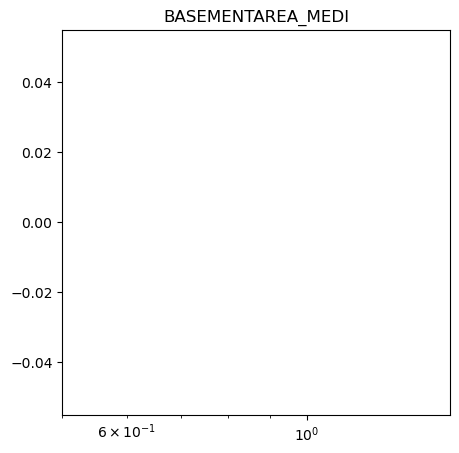

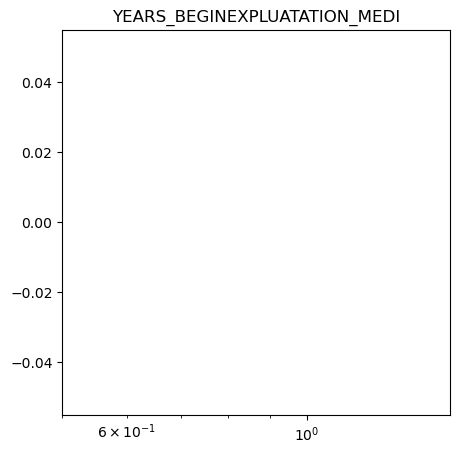

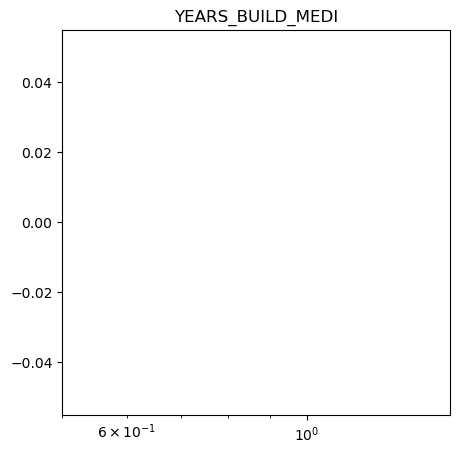

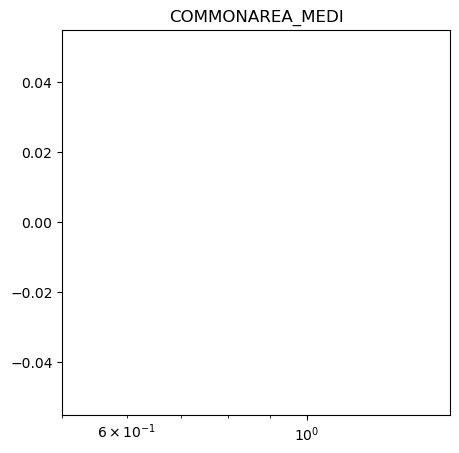

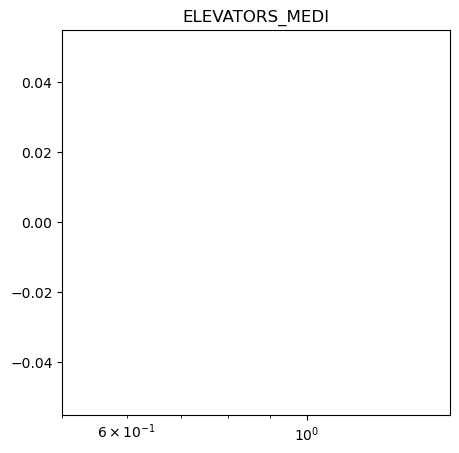

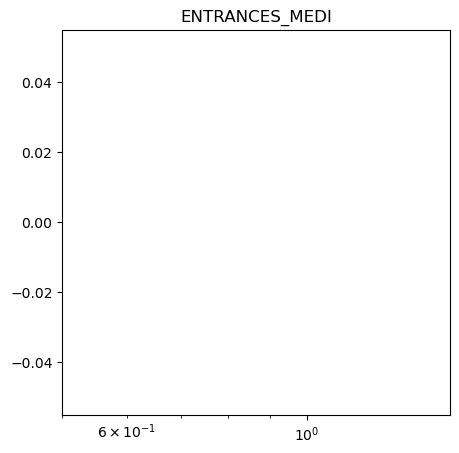

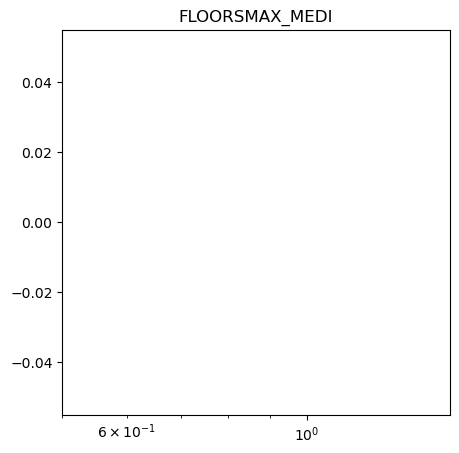

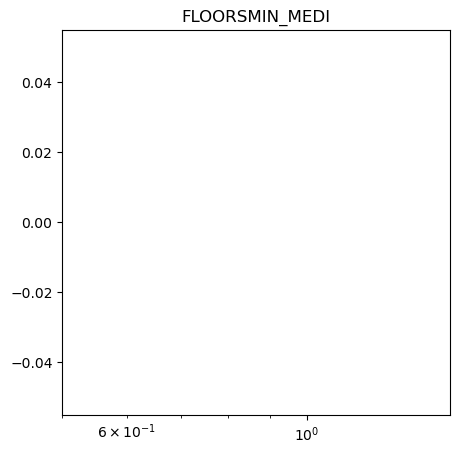

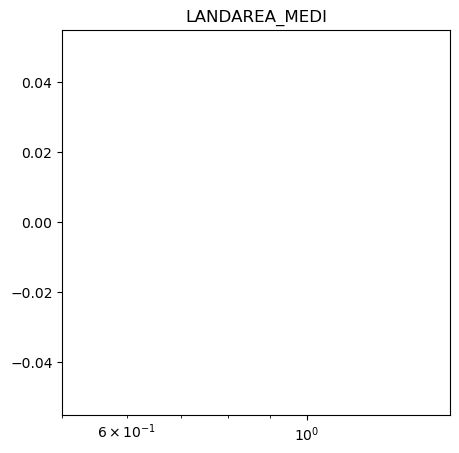

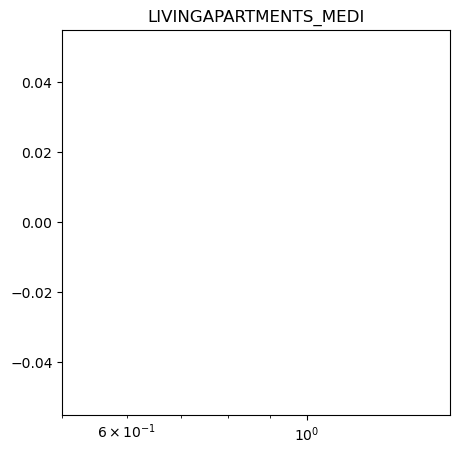

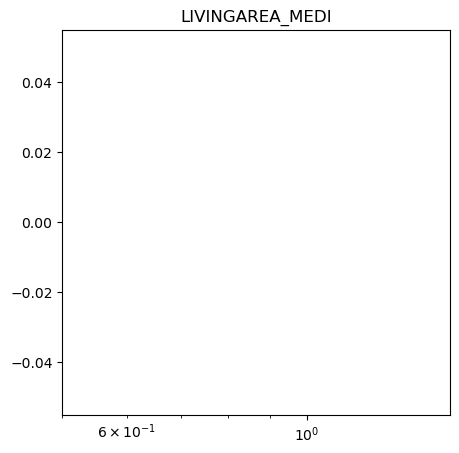

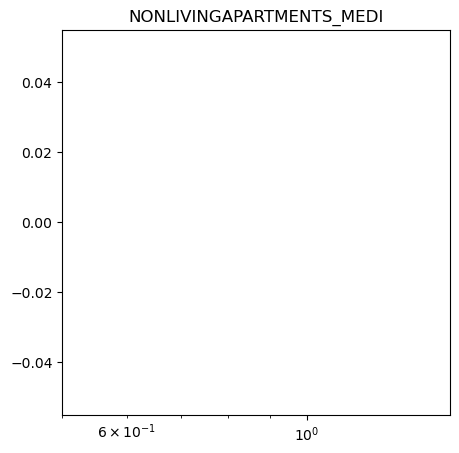

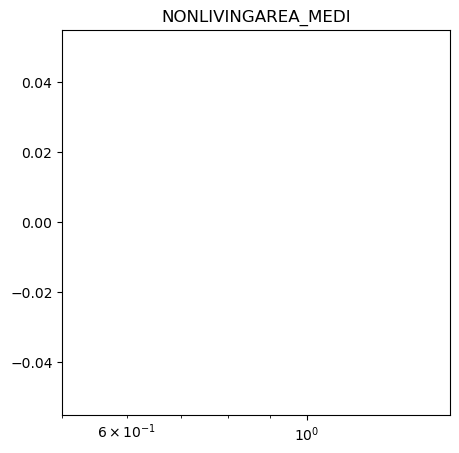

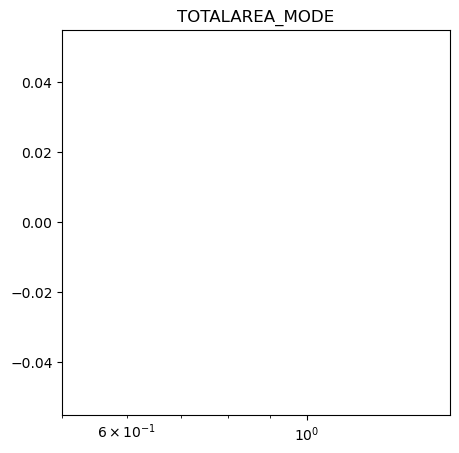

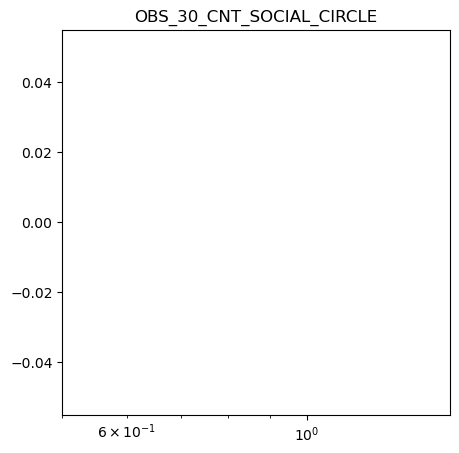

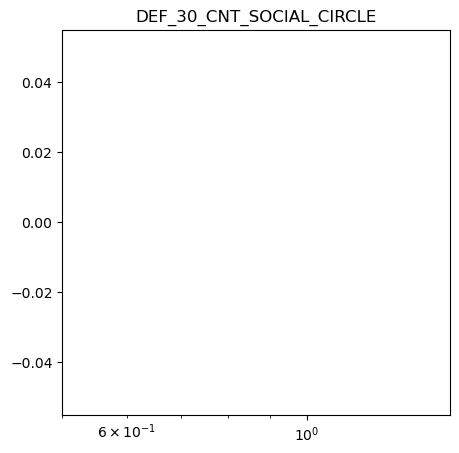

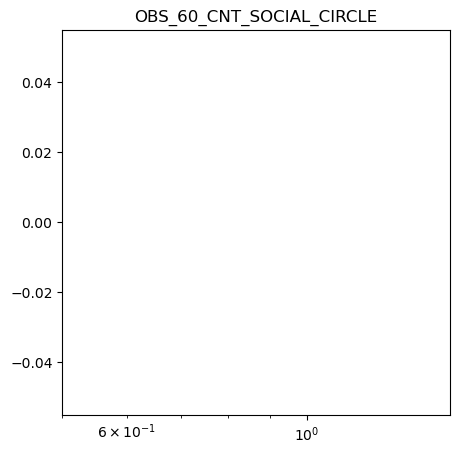

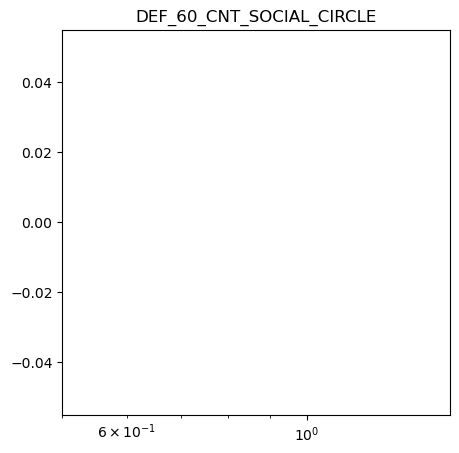

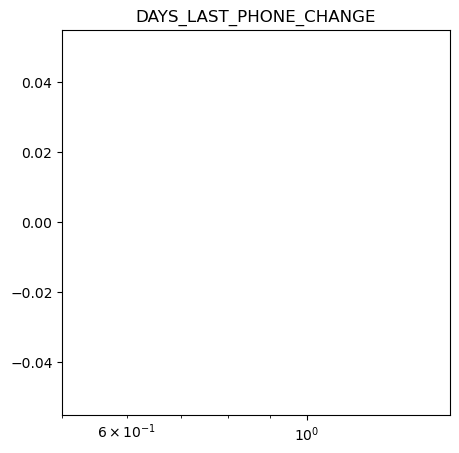

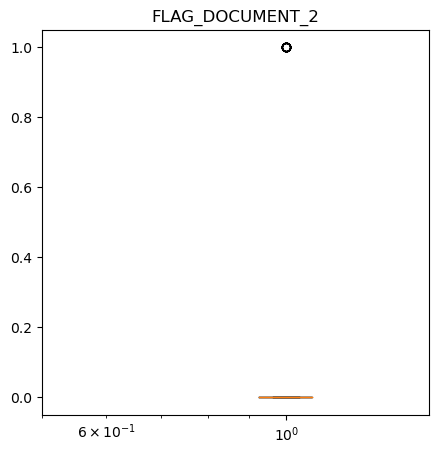

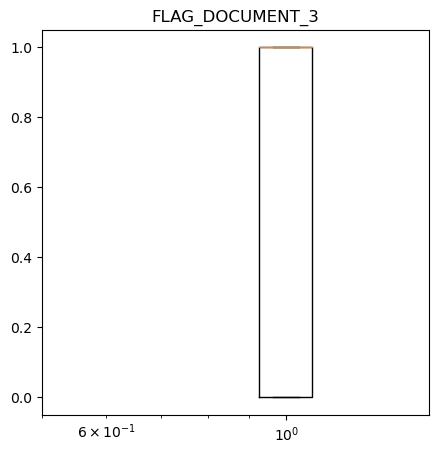

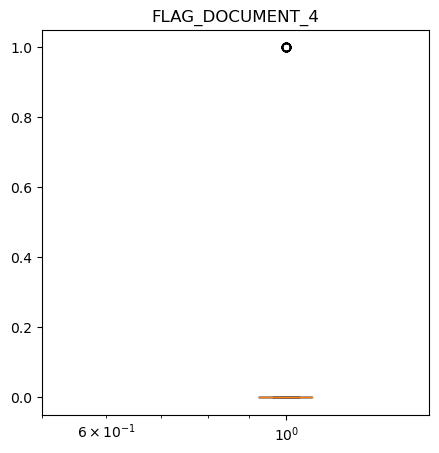

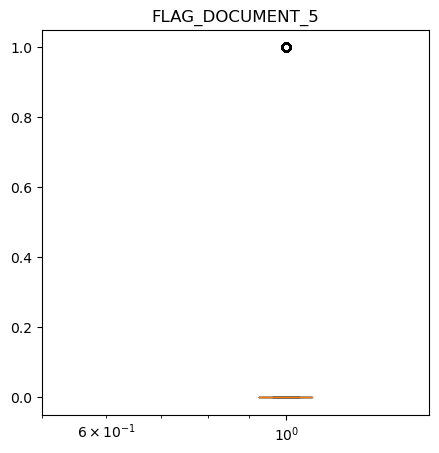

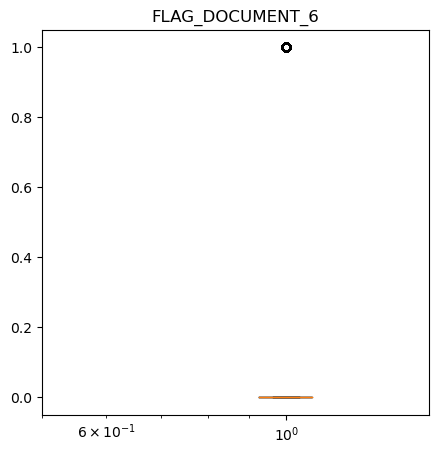

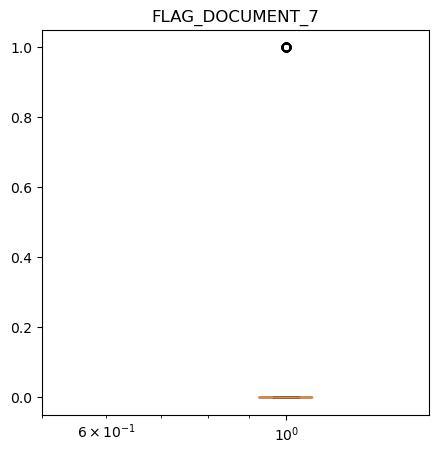

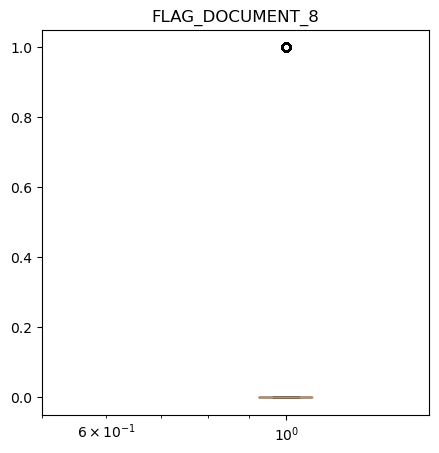

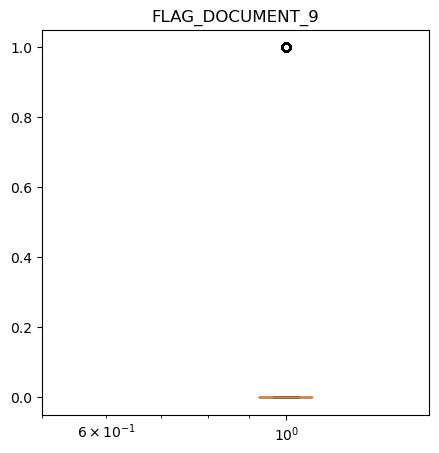

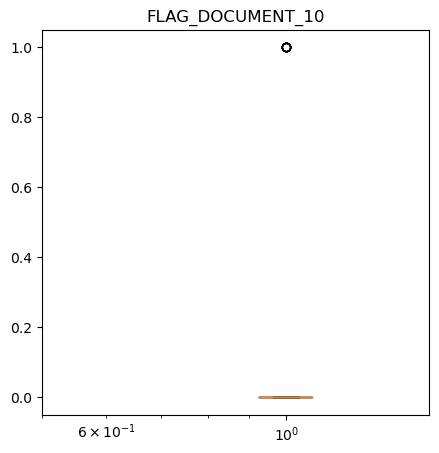

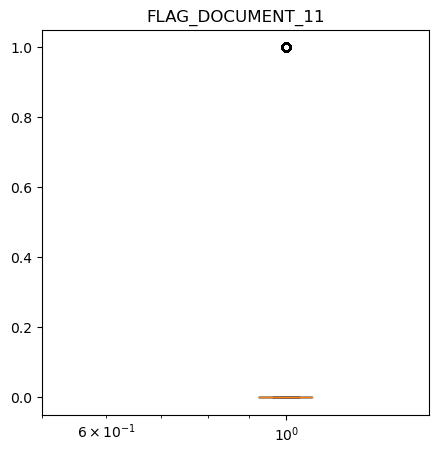

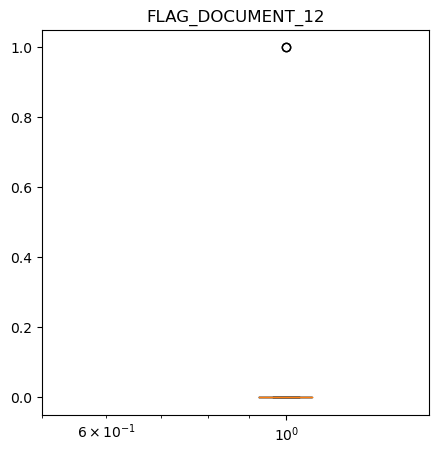

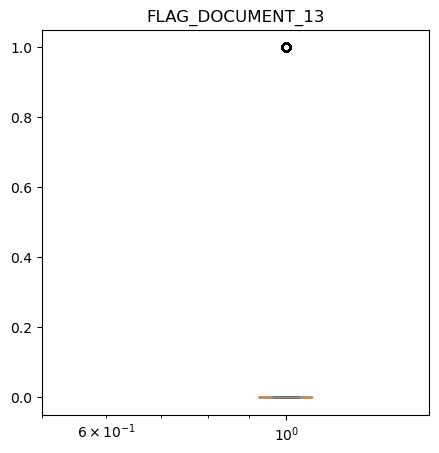

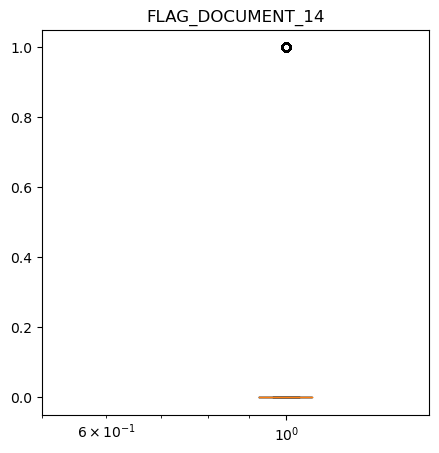

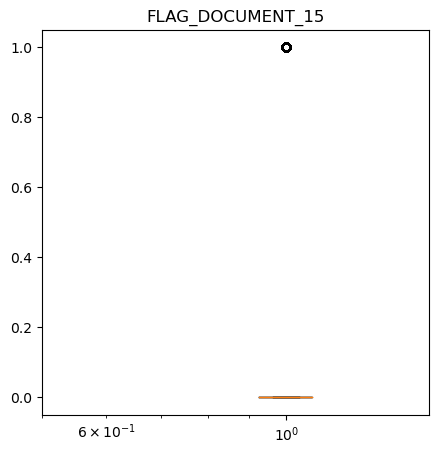

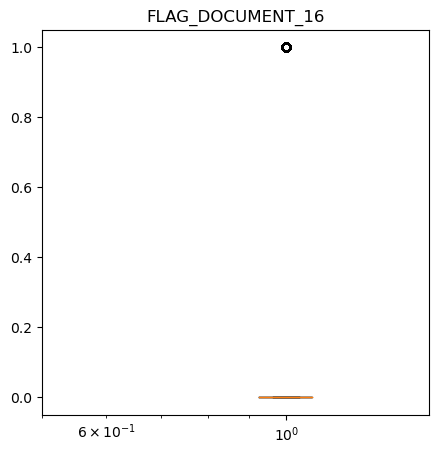

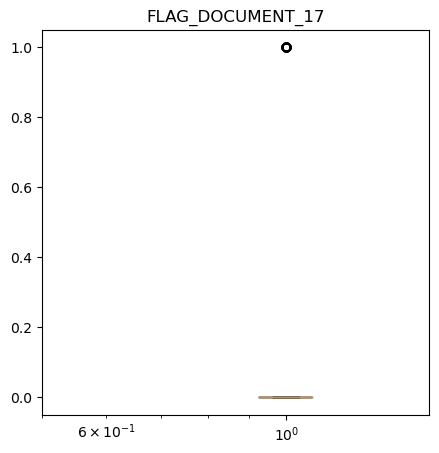

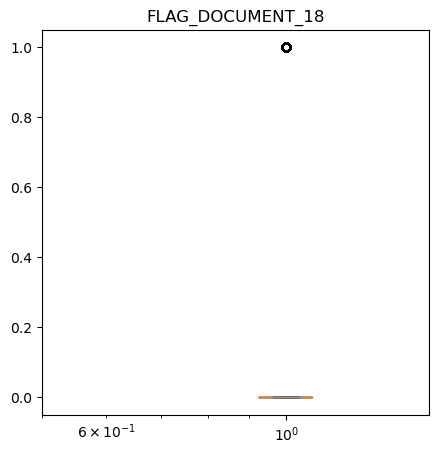

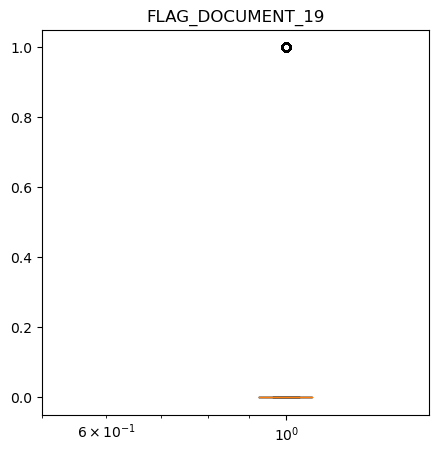

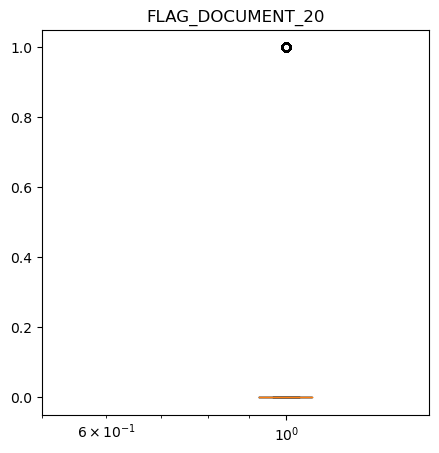

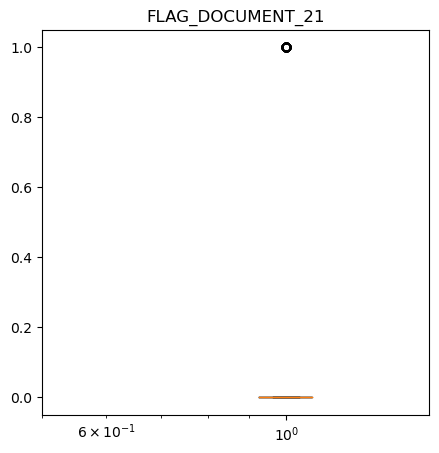

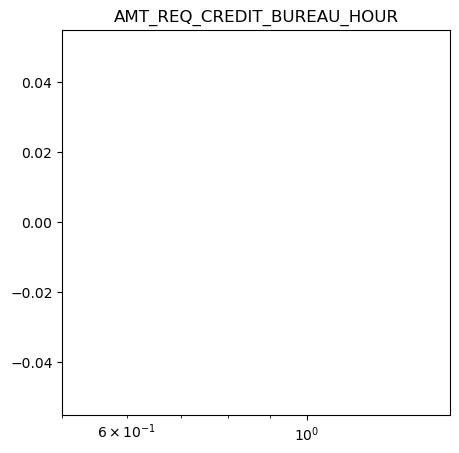

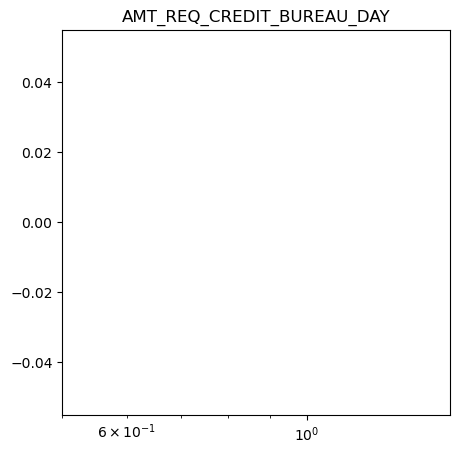

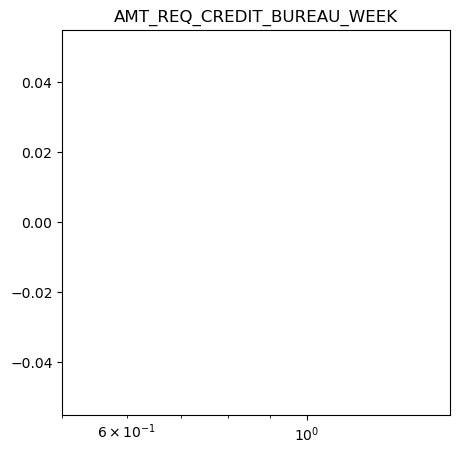

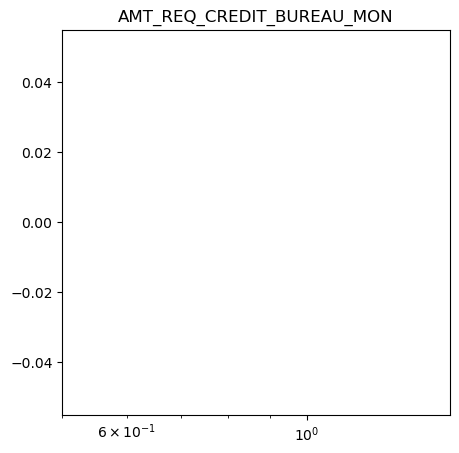

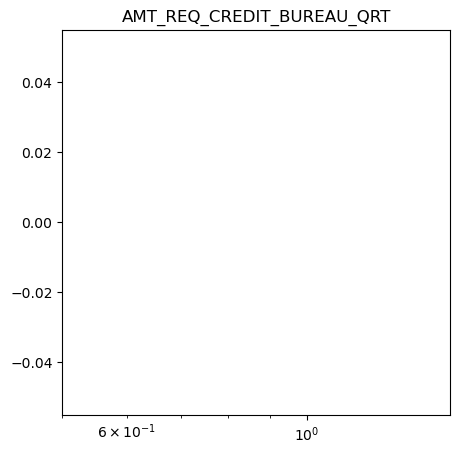

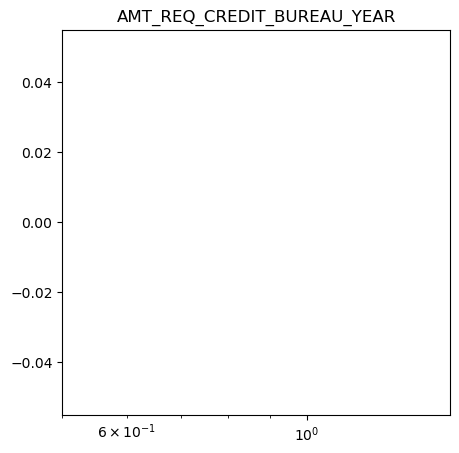

In [23]:
for s in numerical_columns:
   fig = plt.figure(figsize =(5,5))
   plt.boxplot(data[s])
   plt.xscale('log')
   plt.title(s)
   plt.show()
   

## Feature Engineering and Selection
creating new features from existing ones and choosing the most relevant features to improve model performance and interpretability.
## Correlation matrix
is a table that shows the correlation coefficients between variables in a dataset. Correlation coefficients quantify the strength and direction of the linear relationship between two variables. The matrix is symmetric, with the same variables shown on both the rows and columns, and each cell contains the correlation coefficient between the variables corresponding to the row and column.

Positive Correlation (Closer to +1): When the correlation coefficient is close to +1, it indicates a strong positive linear relationship between the variables. This means that as one variable increases, the other variable also tends to increase.

Negative Correlation (Closer to -1): A correlation coefficient close to -1 indicates a strong negative linear relationship. In this case, as one variable increases, the other variable tends to decrease.

No Correlation (Close to 0): A correlation coefficient close to 0 suggests no linear relationship between the variables. Changes in one variable do not correspond to predictable changes in the other variable.

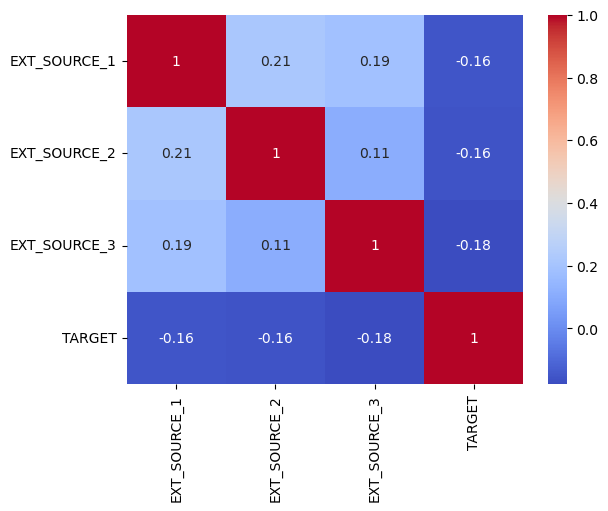

In [22]:

test1 = data[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","TARGET"]]
source_corr = test1.corr()
ax = sns.heatmap(source_corr,
            xticklabels=source_corr.columns,
            yticklabels=source_corr.columns,
            annot = True,
            cmap ="coolwarm",)

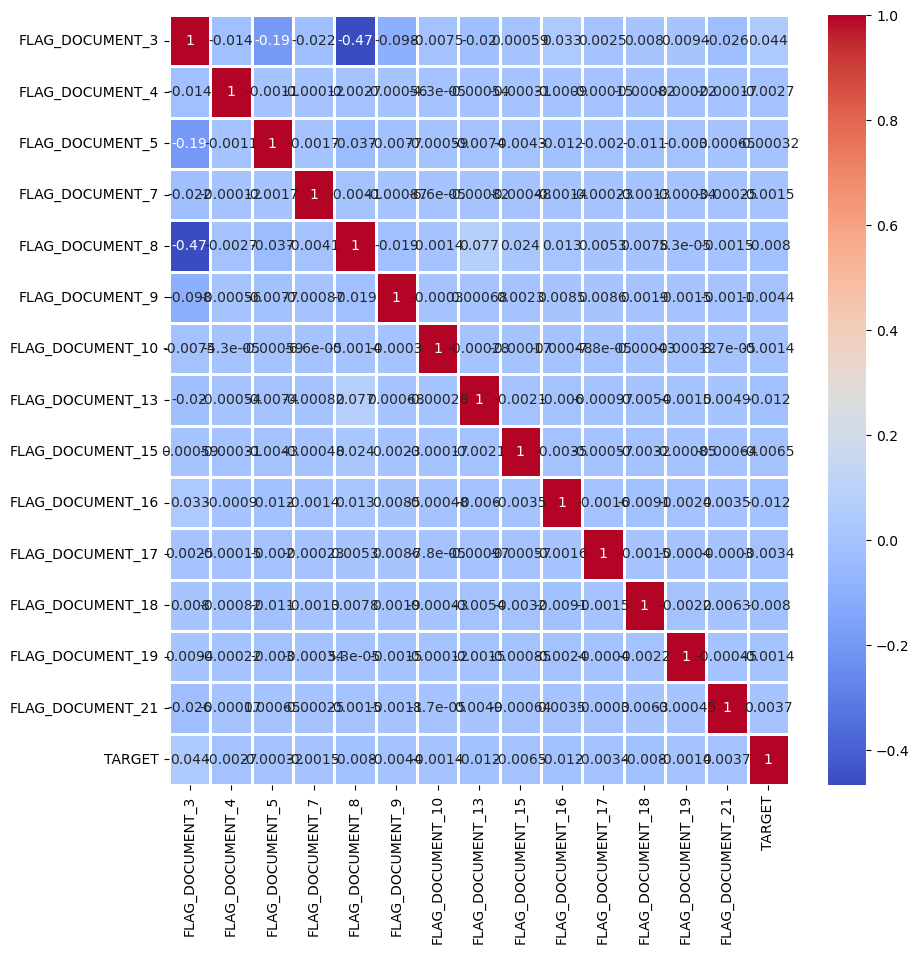

In [23]:
col_Doc = [ 'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','TARGET']
Contact_doc= data[col_Doc].corr()
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(Contact_doc,
            xticklabels=Contact_doc.columns,
            yticklabels=Contact_doc.columns,
            annot = True,
            cmap ="coolwarm",
            linewidth=1)

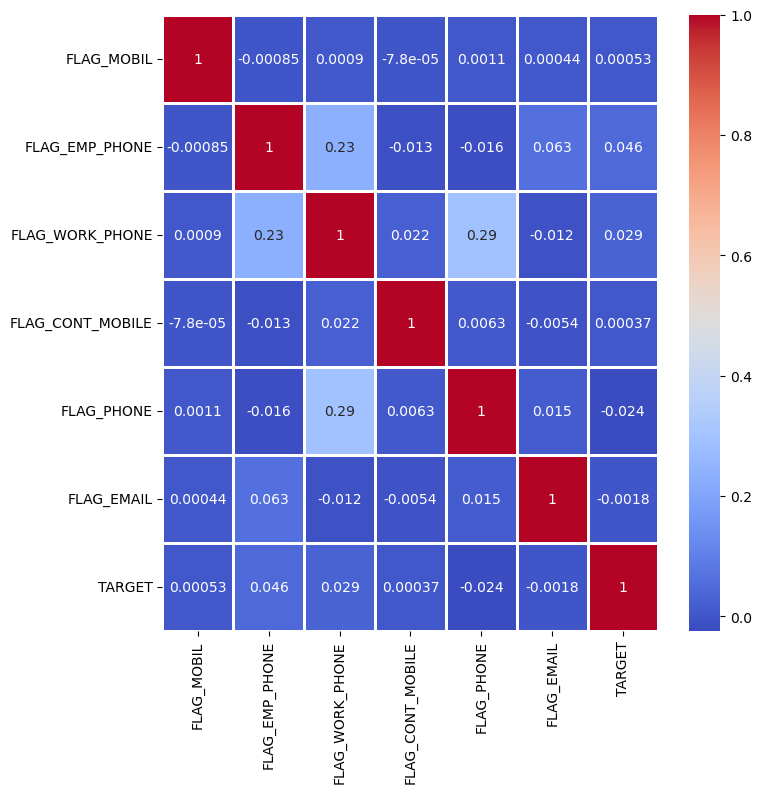

In [24]:
test2 = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL','TARGET']
Contact_corr = data[test2].corr()
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(Contact_corr,
            xticklabels=Contact_corr.columns,
            yticklabels=Contact_corr.columns,
            annot = True,
            cmap ="coolwarm",
            linewidth=1)

we see that test1 , test2 , all col_docs and flags columns does not have a strong relation with target variable so we can drop all of them

In [25]:
x_train=x_train.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL' ,'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_14','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'], axis=1)


In [26]:
x_test=x_test.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL' ,'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_7', 
           'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_14','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'], axis=1)


In [27]:
categorical_columns2 = x_train.select_dtypes(include=['object']).columns
numerical_columns2 = x_train.select_dtypes(include=['int64', 'float64']).columns

In [28]:
x_train.shape

(246008, 93)

In [29]:
x_test.shape

(61503, 93)

## Feature scaling
involves transforming the features of a dataset to a standardized range. The goal of feature scaling is to ensure that the features contribute equally to the model training process and that no single feature dominates because of its larger magnitude.

In [30]:
scaler = StandardScaler()
x_train_scaled=x_train
x_test_scaled=x_test
# Fit the scaler on x_train and transform x_train
x_train_scaled[numerical_columns2]=scaler.fit_transform(x_train[numerical_columns2])

# Transform x_test using the same scaler
x_test_scaled[numerical_columns2]=scaler.transform(x_test[numerical_columns2])

In [31]:
(x_train_scaled.shape)

(246008, 93)

## Target analysis

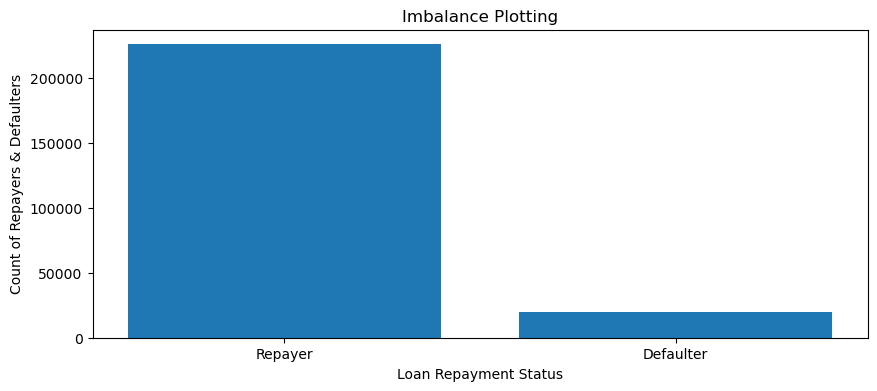

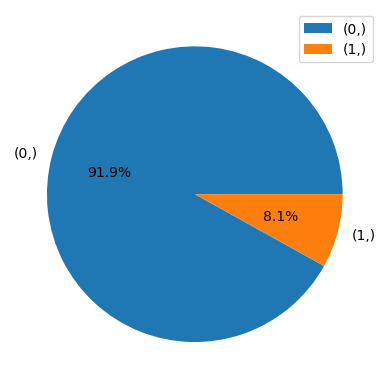

In [32]:
Imbalance = y_train.value_counts()

plt.figure(figsize=(10,4))
z= ['Repayer','Defaulter']
plt.bar(z, Imbalance)
plt.xlabel("Loan Repayment Status")
plt.ylabel("Count of Repayers & Defaulters")
plt.title("Imbalance Plotting")
plt.show()

plt.pie(Imbalance,labels=Imbalance.index,autopct='%1.1f%%')
plt.legend()

## we see there is imbalance here we will solve it later

## Encoding

In [33]:
print(categorical_columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [34]:
col_in=x_train_scaled.columns.get_indexer(categorical_columns)
print(col_in)

[ 0  1  2  3  9 10 11 12 13 20 24 32 75 76 78 79]


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Define the ColumnTransformer object. We have passed to it the column indices that need encoding
ct_obj =  ColumnTransformer(transformers= [("encoder", OneHotEncoder(handle_unknown='ignore'),[   0 , 1 , 2 , 3 , 9 ,10, 11, 12 ,13, 20, 24, 32 ,75, 76, 78, 79])] , remainder="passthrough") 
# Encode the categorical data in a similiar approach as above using the ct_obj
x_train_enc=np.array(ct_obj.fit_transform(x_train_scaled))
x_test_enc=np.array(ct_obj.transform(x_test_scaled))

In [36]:
x_train_enc.shape

(246008, 215)

In [37]:
cat=x_train_scaled.select_dtypes(include=['object'])
num=x_train_scaled.select_dtypes(exclude=['object'])
transformed_column_names =ct_obj.named_transformers_['encoder'].get_feature_names_out(cat.columns.tolist())


In [38]:
cat_test=x_test_scaled.select_dtypes(include=['object'])
num_test=x_test_scaled.select_dtypes(exclude=['object'])
transformed_column_names_test =ct_obj.named_transformers_['encoder'].get_feature_names_out(cat_test.columns.tolist())


In [39]:
columns_names=num.columns.tolist()+transformed_column_names.tolist()
columns_names_test=num_test.columns.tolist()+transformed_column_names_test.tolist()

In [40]:
x_train_df = pd.DataFrame(x_train_enc, columns=columns_names)
x_test_df = pd.DataFrame(x_test_enc, columns=columns_names_test)

## Handling imbalance using SMOT


In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Fit and transform on the original data to obtain the oversampled data
X_train_oversampled, y_train_oversampled = smote.fit_resample(x_train_df, y_train)


In [42]:
print(x_train_df.shape[0])
print(X_train_oversampled.shape[0])

246008
452296


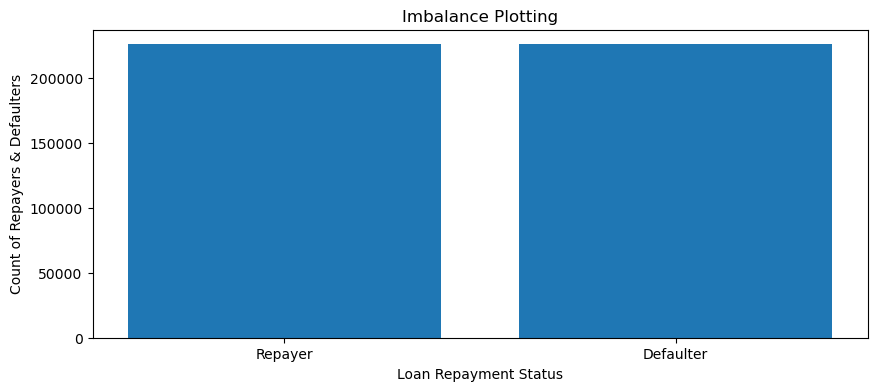

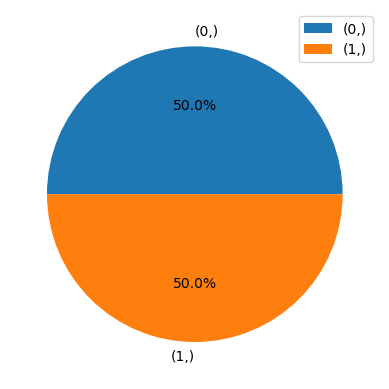

In [43]:
Imbalance = y_train_oversampled.value_counts()

plt.figure(figsize=(10,4))
z= ['Repayer','Defaulter']
plt.bar(z, Imbalance)
plt.xlabel("Loan Repayment Status")
plt.ylabel("Count of Repayers & Defaulters")
plt.title("Imbalance Plotting")
plt.show()

plt.pie(Imbalance,labels=Imbalance.index,autopct='%1.1f%%')
plt.legend()

# some features we forgot to drop when doing correlation matrix 

In [47]:
x_train_selected = X_train_oversampled
x_test_selected=x_test_df
x_train_selected=x_train_selected.drop(['LIVINGAPARTMENTS_AVG','REG_REGION_NOT_WORK_REGION','HOUR_APPR_PROCESS_START','REG_CITY_NOT_WORK_CITY','NAME_TYPE_SUITE_Other_B','NAME_HOUSING_TYPE_House / apartment','NAME_EDUCATION_TYPE_Higher education',
                                        'BASEMENTAREA_AVG' ,'NAME_HOUSING_TYPE_Municipal apartment','FLAG_OWN_CAR_Y','LIVE_CITY_NOT_WORK_CITY'],axis=1)
x_test_selected=x_test_selected.drop(['LIVINGAPARTMENTS_AVG','REG_REGION_NOT_WORK_REGION','HOUR_APPR_PROCESS_START','REG_CITY_NOT_WORK_CITY','NAME_TYPE_SUITE_Other_B','NAME_HOUSING_TYPE_House / apartment','NAME_EDUCATION_TYPE_Higher education',
                                        'BASEMENTAREA_AVG' ,'NAME_HOUSING_TYPE_Municipal apartment','FLAG_OWN_CAR_Y','LIVE_CITY_NOT_WORK_CITY'],axis=1)

## Modeling

# RandomForestClassifier

In [48]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
# fit the model to the training set
clf.fit(x_train_selected, y_train_oversampled)
# Predict on the test set results
y_pred = clf.predict(x_test_selected)
# Check accuracy score 
print('Model accuracy score  : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model accuracy score  : 0.9192


In [49]:
# Generate classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.33      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.63      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



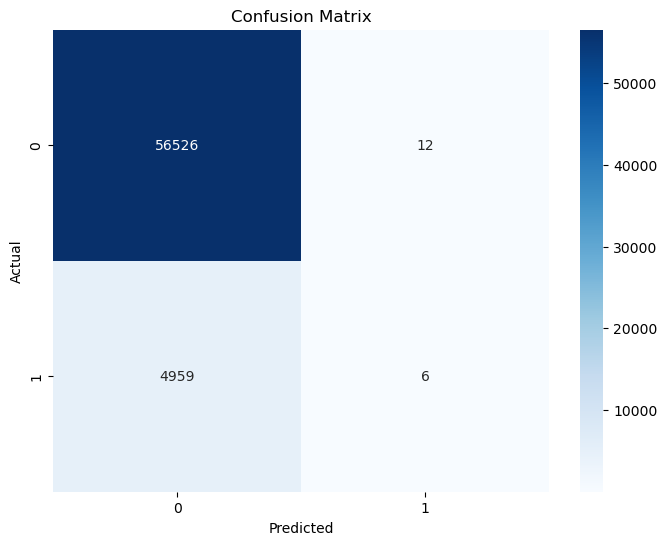

In [50]:
# Generate confusion matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
import joblib

# Save the model to a file
joblib.dump(clf, 'customer_default_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [52]:
import json
# Get the list of feature names
feature_names = list(x_train_selected.columns)

# Save the feature names to a JSON file
with open("feature_names.json", "w") as f:
    json.dump(feature_names, f)

# Logisitic reg

In [53]:
model = LogisticRegression(random_state=42 ,max_iter=2000)

# Convert DataFrame to numpy array and flatten
y_train_undersampled_1d = y_train_oversampled.values.ravel()

# Train the model on the training data
model.fit(x_train_selected, y_train_undersampled_1d)

# Make predictions on the test data
y_pred = model.predict(x_test_selected)

# Generate a classification report
report = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print("Classification Report:\n", report)

Accuracy: 0.6401151163357885
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77     56538
           1       0.13      0.62      0.22      4965

    accuracy                           0.64     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.88      0.64      0.72     61503



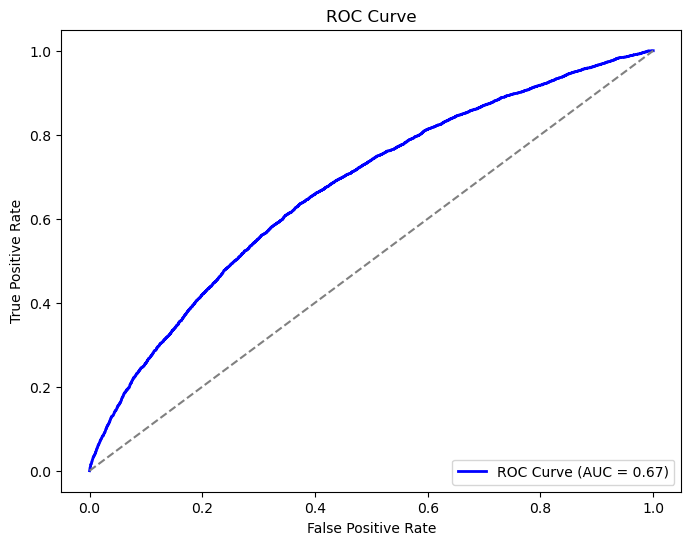

In [54]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(x_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



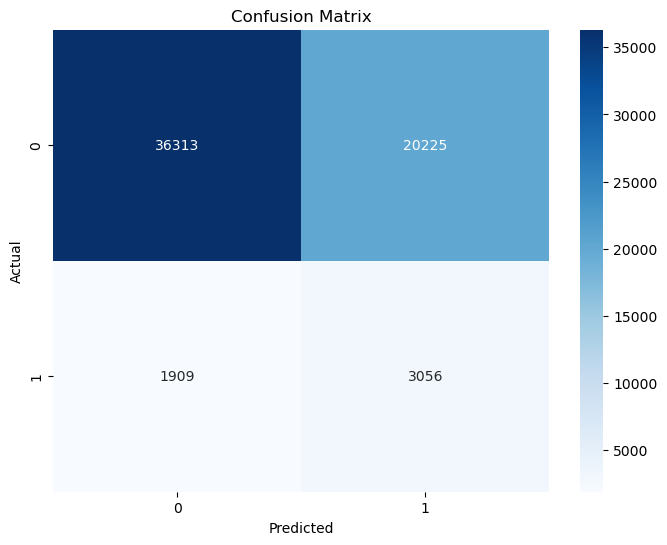

In [55]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# to be repeated 

# XGBClassifier

In [50]:
from sklearn.metrics import classification_report

# Create an XGBoost classifier with a random state
model = XGBClassifier(random_state=42)

# Train the model on the training data
model.fit(x_train_selected, y_train_oversampled)

# Make predictions on the test data
y_pred = model.predict(x_test_selected)

# Generate a classification report
report = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print("Classification Report:\n", report)


Accuracy: 0.9190283400809717
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.35      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.63      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



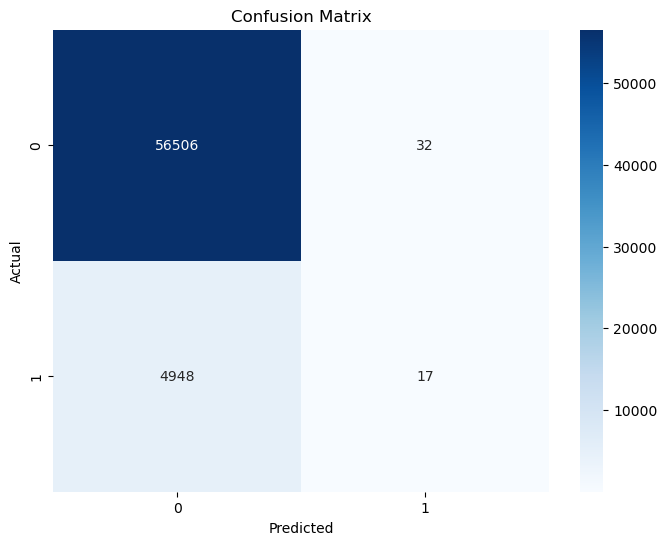

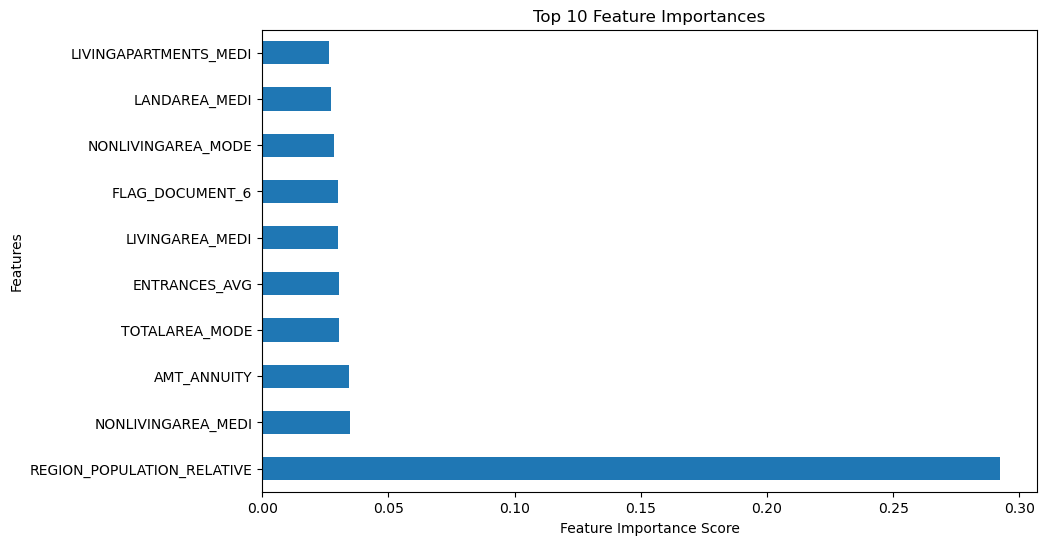

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=x_train_selected.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()

# DecisionTreeClassifier

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a Decision Tree classifier with a random state
model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
model.fit(x_train_selected, y_train_oversampled)

# Make predictions on the test data
y_pred = model.predict(x_test_selected)

# Generate a classification report
report = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print("Classification Report:\n", report)


Accuracy: 0.8401541388224965
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     56538
           1       0.11      0.13      0.12      4965

    accuracy                           0.84     61503
   macro avg       0.51      0.52      0.51     61503
weighted avg       0.86      0.84      0.85     61503

